<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher_New/blob/main/swin_transformer_pip_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.optim import AdamW
from torchvision import transforms

In [23]:
# -----------------------------
# 乱数シード固定用関数
# -----------------------------
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

# ここで好きなシード値を指定
seed = 42
seed_everything(seed)

# -----------------------------
# デバイス設定
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# CSVファイルの読み込み
# -----------------------------
csv_path = "/content/drive/MyDrive/pip_table.csv"
data = pd.read_csv(csv_path)

# 画像ファイルへのパスを生成 (filename 列を想定)
data['image_path'] = data.apply(
    lambda row: os.path.join("/content/drive/MyDrive/pip_for_analysis", row["filename"]),
    axis=1
)

In [24]:
batch_size=64
epochs = 200
lr = 0.1*3e-4
gamma = 0.85
seed = 42
#dropout_of_model('swin_base_patch4_window7_224.ms_in1k')
drop_rate=0.5
attn_drop_rate=0.4
drop_path_rate=0.4
mixup_alpha=0.5
#optimizer's_settings(AdamW)
weight_decay=6e-3
#scheduler's_settings(CosineAnnealingWarmRestarts)
T_0=200
T_mult=1
eta_min=1e-6

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)
device = 'cuda'

train_transforms=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=25),
    transforms.RandomAffine(degrees=0, translate=(0.12, 0.12), scale=(0.75, 1.25)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.4),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class ImageDataset(Dataset):
    """
    RA画像データセット
    positive_class (ra=1): RA患者の画像
    negative_class (ra=0): 非RA患者の画像
    """
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # クラスの分布を計算
        self.class_distribution = self.dataframe['ra'].value_counts()
        print(f"Class distribution:")
        print(f"RA positive (ra=1): {self.class_distribution.get(1, 0)}")
        print(f"RA negative (ra=0): {self.class_distribution.get(0, 0)}")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')

        # ラベルを明示的に int型 で取得（1: RA positive, 0: RA negative）
        label = int(self.dataframe.iloc[idx]['ra'])

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_pos_weight(self):
        """
        クラス不均衡に対するポジティブクラスの重みを計算
        BCEWithLogitsLossのpos_weightパラメータとして使用可能
        """
        neg_count = self.class_distribution.get(0, 0)
        pos_count = self.class_distribution.get(1, 0)
        return torch.tensor([neg_count / pos_count]) if pos_count > 0 else torch.tensor([1.0])

from sklearn.model_selection import train_test_split

# 元のデータをトレーニングセットとテストセットに分割
train_val_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

# トレーニングセットをさらにトレーニングセットとバリデーションセットに分割
train_data, val_data = train_test_split(train_val_data, test_size=0.22, random_state=42)  # 0.22 ≈ 2/9

# トレーニング、バリデーション、テストセット用のデータセットとデータローダーを作成
train_dataset = ImageDataset(train_data, transform=train_transforms)
valid_dataset = ImageDataset(val_data, transform=val_transforms)
test_dataset = ImageDataset(test_data, transform=test_transforms)


# データローダーの設定を最適化
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

model_names = timm.list_models(pretrained=True)
model = timm.create_model(
    'swin_base_patch4_window7_224.ms_in1k',
    pretrained=True,
    num_classes=2,
    drop_block_rate=None,
    drop_connect_rate=None,
    drop_rate=drop_rate,
    attn_drop_rate=attn_drop_rate,
    drop_path_rate=drop_path_rate,
)
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
# criterion = nn.HuberLoss()
# optimizer
optimizer = AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingWarmRestarts
"""
# Warmupスケジューラーの設定
warmup_epochs = 15
warmup_scheduler = LinearLR(
    optimizer,
    start_factor=1e-6/lr,  # 初期学習率/目標学習率
    end_factor=1.0,
    total_iters=warmup_epochs
)

# メインのスケジューラー（既存のCosineAnnealingWarmRestarts）
cosine_scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=T_0,
    T_mult=T_mult,
    eta_min=eta_min
)

# 二つのスケジューラーを結合
scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[warmup_epochs]
)
"""
#scheduler = StepLR(optimizer, step_size=3, gamma=gamma)
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=T_0,
    T_mult=T_mult,
    eta_min=eta_min
)
"""
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-5,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1000
)"""

Class distribution:
RA positive (ra=1): 764
RA negative (ra=0): 1802
Class distribution:
RA positive (ra=1): 216
RA negative (ra=0): 508
Class distribution:
RA positive (ra=1): 109
RA negative (ra=0): 257


"\nscheduler = torch.optim.lr_scheduler.OneCycleLR(\n    optimizer,\n    max_lr=1e-5,\n    epochs=epochs,\n    steps_per_epoch=len(train_loader),\n    pct_start=0.1,\n    anneal_strategy='cos',\n    div_factor=25,\n    final_div_factor=1000\n)"

学習ループを設定し、実行していく

In [25]:
import gc
from torchvision.utils import make_grid

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ':'.join([
    'max_split_size_mb:128',
    'expandable_segments:True'
])

class Mixup:
    def __init__(self, alpha=mixup_alpha):
        self.alpha = alpha

    def __call__(self, batch, target):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = len(batch)
        index = torch.randperm(batch_size).to(batch.device)

        mixed_batch = lam * batch + (1 - lam) * batch[index, :]
        target_a, target_b = target, target[index]
        return mixed_batch, target_a, target_b, lam

def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    # 新しい指標のリストを追加
    val_sensitivity_list = []
    val_specificity_list = []
    val_f1_list = []
    test_sensitivity_list = []
    test_specificity_list = []
    test_f1_list = []

    scaler = torch.cuda.amp.GradScaler()
    mixup = Mixup(alpha=mixup_alpha)

    def calculate_metrics(outputs, labels):
        predictions = outputs.argmax(dim=1)
        tp = ((predictions == 1) & (labels == 1)).float().sum()
        tn = ((predictions == 0) & (labels == 0)).float().sum()
        fp = ((predictions == 1) & (labels == 0)).float().sum()
        fn = ((predictions == 0) & (labels == 1)).float().sum()

        sensitivity = tp / (tp + fn + 1e-7)
        specificity = tn / (tn + fp + 1e-7)
        precision = tp / (tp + fp + 1e-7)
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-7)

        return sensitivity.item(), specificity.item(), f1_score.item()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                mixed_data, labels_a, labels_b, lam = mixup(data, label)

                output = model(mixed_data)
                loss = criterion(output, labels_a) * lam + criterion(output, labels_b) * (1 - lam)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            acc = (lam * (output.argmax(dim=1) == labels_a).float() +
                  (1 - lam) * (output.argmax(dim=1) == labels_b).float()).mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, mixed_data, labels_a, labels_b, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()

        # 検証フェーズ
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            val_outputs = []
            val_labels = []

            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                val_outputs.append(val_output)
                val_labels.append(label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

            # 検証データセット全体での指標計算
            val_outputs = torch.cat(val_outputs)
            val_labels = torch.cat(val_labels)
            val_sensitivity, val_specificity, val_f1 = calculate_metrics(val_outputs, val_labels)

            # テストフェーズ
            epoch_test_accuracy = 0
            epoch_test_loss = 0
            test_outputs = []
            test_labels = []

            for data, label in tqdm(test_loader):
                data = data.to(device)
                label = label.to(device)

                test_output = model(data)
                test_loss = criterion(test_output, label)

                test_outputs.append(test_output)
                test_labels.append(label)

                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss / len(test_loader)

                del data, label, test_output, test_loss

            # テストデータセット全体での指標計算
            test_outputs = torch.cat(test_outputs)
            test_labels = torch.cat(test_labels)
            test_sensitivity, test_specificity, test_f1 = calculate_metrics(test_outputs, test_labels)

            torch.cuda.empty_cache()

        # 結果の記録
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        test_acc_list.append(epoch_test_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)
        test_loss_list.append(epoch_test_loss)

        # 新しい指標の記録
        val_sensitivity_list.append(val_sensitivity)
        val_specificity_list.append(val_specificity)
        val_f1_list.append(val_f1)
        test_sensitivity_list.append(test_sensitivity)
        test_specificity_list.append(test_specificity)
        test_f1_list.append(test_f1)

        print(
            f"Epoch : {epoch+1} - "
            f"train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} - "
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - "
            f"val_sensitivity: {val_sensitivity:.4f} - val_specificity: {val_specificity:.4f} - val_f1: {val_f1:.4f} - "
            f"test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f} - "
            f"test_sensitivity: {test_sensitivity:.4f} - test_specificity: {test_specificity:.4f} - test_f1: {test_f1:.4f}\n"
        )

        scheduler.step()

    return (train_acc_list, val_acc_list, test_acc_list,
            train_loss_list, val_loss_list, test_loss_list,
            val_sensitivity_list, val_specificity_list, val_f1_list,
            test_sensitivity_list, test_specificity_list, test_f1_list)

# モデルの設定を最適化
def optimize_model_settings():
    # メモリ関連の設定を最適化
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

    # モデルの設定を最適化
    model.to(device)
    if hasattr(model, 'transformer'):
        for block in model.transformer.blocks:
            block.attn.fused_attn = True

    return model

def main():
    model = optimize_model_settings()
    metrics = train_with_gradient_accumulation(
        model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs
    )
    return (model, *metrics)

# 実行
model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list, \
    val_sensitivity_list, val_specificity_list, val_f1_list, \
    test_sensitivity_list, test_specificity_list, test_f1_list = main()

<ipython-input-25-ad02b673bba0>:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-25-ad02b673bba0>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 1 - train_loss : 0.6632 - train_acc: 0.6692 - val_loss : 0.6334 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6378 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 0.6353 - train_acc: 0.6997 - val_loss : 0.6286 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6346 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 0.6365 - train_acc: 0.6981 - val_loss : 0.6306 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6348 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 0.6374 - train_acc: 0.6974 - val_loss : 0.6290 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6336 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 0.6359 - train_acc: 0.6978 - val_loss : 0.6270 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6322 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 6 - train_loss : 0.6374 - train_acc: 0.6978 - val_loss : 0.6299 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6354 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 7 - train_loss : 0.6276 - train_acc: 0.7052 - val_loss : 0.6273 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6329 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 8 - train_loss : 0.6298 - train_acc: 0.7015 - val_loss : 0.6331 - val_acc: 0.7031 - val_sensitivity: 0.0046 - val_specificity: 0.9961 - val_f1: 0.0091 - test_loss : 0.6387 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 9 - train_loss : 0.6255 - train_acc: 0.7029 - val_loss : 0.6256 - val_acc: 0.7057 - val_sensitivity: 0.0093 - val_specificity: 0.9980 - val_f1: 0.0183 - test_loss : 0.6329 - test_acc: 0.6972 - test_sensitivity: 0.0000 - test_specificity: 0.9961 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 10 - train_loss : 0.6280 - train_acc: 0.7045 - val_loss : 0.6237 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6301 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 11 - train_loss : 0.6265 - train_acc: 0.7085 - val_loss : 0.6311 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6346 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 12 - train_loss : 0.6241 - train_acc: 0.7048 - val_loss : 0.6206 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6261 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 13 - train_loss : 0.6269 - train_acc: 0.7019 - val_loss : 0.6192 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6252 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 14 - train_loss : 0.6302 - train_acc: 0.7044 - val_loss : 0.6233 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6282 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 15 - train_loss : 0.6260 - train_acc: 0.7057 - val_loss : 0.6331 - val_acc: 0.7031 - val_sensitivity: 0.0046 - val_specificity: 0.9961 - val_f1: 0.0091 - test_loss : 0.6361 - test_acc: 0.6962 - test_sensitivity: 0.0000 - test_specificity: 0.9961 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 16 - train_loss : 0.6255 - train_acc: 0.7019 - val_loss : 0.6272 - val_acc: 0.7031 - val_sensitivity: 0.0000 - val_specificity: 0.9980 - val_f1: 0.0000 - test_loss : 0.6305 - test_acc: 0.6962 - test_sensitivity: 0.0000 - test_specificity: 0.9961 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 17 - train_loss : 0.6268 - train_acc: 0.6974 - val_loss : 0.6195 - val_acc: 0.7044 - val_sensitivity: 0.0046 - val_specificity: 0.9980 - val_f1: 0.0092 - test_loss : 0.6232 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 18 - train_loss : 0.6226 - train_acc: 0.6968 - val_loss : 0.6197 - val_acc: 0.7031 - val_sensitivity: 0.0324 - val_specificity: 0.9843 - val_f1: 0.0606 - test_loss : 0.6234 - test_acc: 0.7077 - test_sensitivity: 0.0275 - test_specificity: 1.0000 - test_f1: 0.0536



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 19 - train_loss : 0.6337 - train_acc: 0.6893 - val_loss : 0.6382 - val_acc: 0.7018 - val_sensitivity: 0.0509 - val_specificity: 0.9744 - val_f1: 0.0917 - test_loss : 0.6397 - test_acc: 0.6978 - test_sensitivity: 0.0459 - test_specificity: 0.9805 - test_f1: 0.0840



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 20 - train_loss : 0.6280 - train_acc: 0.6988 - val_loss : 0.6241 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6273 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 21 - train_loss : 0.6206 - train_acc: 0.7094 - val_loss : 0.6212 - val_acc: 0.7031 - val_sensitivity: 0.0000 - val_specificity: 0.9980 - val_f1: 0.0000 - test_loss : 0.6249 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 22 - train_loss : 0.6236 - train_acc: 0.7050 - val_loss : 0.6150 - val_acc: 0.7044 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6203 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 23 - train_loss : 0.6219 - train_acc: 0.6973 - val_loss : 0.6146 - val_acc: 0.7044 - val_sensitivity: 0.0093 - val_specificity: 0.9961 - val_f1: 0.0182 - test_loss : 0.6204 - test_acc: 0.7014 - test_sensitivity: 0.0183 - test_specificity: 0.9961 - test_f1: 0.0357



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 24 - train_loss : 0.6199 - train_acc: 0.7020 - val_loss : 0.6107 - val_acc: 0.7031 - val_sensitivity: 0.0278 - val_specificity: 0.9862 - val_f1: 0.0524 - test_loss : 0.6173 - test_acc: 0.7077 - test_sensitivity: 0.0275 - test_specificity: 1.0000 - test_f1: 0.0536



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 25 - train_loss : 0.6224 - train_acc: 0.6999 - val_loss : 0.6149 - val_acc: 0.7096 - val_sensitivity: 0.0278 - val_specificity: 0.9961 - val_f1: 0.0536 - test_loss : 0.6213 - test_acc: 0.7040 - test_sensitivity: 0.0275 - test_specificity: 0.9961 - test_f1: 0.0531



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 26 - train_loss : 0.6190 - train_acc: 0.6992 - val_loss : 0.6118 - val_acc: 0.7044 - val_sensitivity: 0.0278 - val_specificity: 0.9882 - val_f1: 0.0526 - test_loss : 0.6186 - test_acc: 0.7103 - test_sensitivity: 0.0367 - test_specificity: 1.0000 - test_f1: 0.0708



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 27 - train_loss : 0.6209 - train_acc: 0.6966 - val_loss : 0.6173 - val_acc: 0.7044 - val_sensitivity: 0.0602 - val_specificity: 0.9744 - val_f1: 0.1074 - test_loss : 0.6221 - test_acc: 0.7040 - test_sensitivity: 0.0642 - test_specificity: 0.9805 - test_f1: 0.1157



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 28 - train_loss : 0.6212 - train_acc: 0.6960 - val_loss : 0.6150 - val_acc: 0.7068 - val_sensitivity: 0.1019 - val_specificity: 0.9646 - val_f1: 0.1719 - test_loss : 0.6191 - test_acc: 0.7066 - test_sensitivity: 0.0826 - test_specificity: 0.9767 - test_f1: 0.1452



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 29 - train_loss : 0.6168 - train_acc: 0.7071 - val_loss : 0.6201 - val_acc: 0.7042 - val_sensitivity: 0.1065 - val_specificity: 0.9587 - val_f1: 0.1769 - test_loss : 0.6218 - test_acc: 0.7066 - test_sensitivity: 0.0917 - test_specificity: 0.9728 - test_f1: 0.1587



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 30 - train_loss : 0.6195 - train_acc: 0.6944 - val_loss : 0.6130 - val_acc: 0.7029 - val_sensitivity: 0.0926 - val_specificity: 0.9626 - val_f1: 0.1569 - test_loss : 0.6148 - test_acc: 0.7118 - test_sensitivity: 0.0826 - test_specificity: 0.9844 - test_f1: 0.1475



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 31 - train_loss : 0.6209 - train_acc: 0.7009 - val_loss : 0.6206 - val_acc: 0.7096 - val_sensitivity: 0.0463 - val_specificity: 0.9882 - val_f1: 0.0862 - test_loss : 0.6229 - test_acc: 0.7040 - test_sensitivity: 0.0367 - test_specificity: 0.9922 - test_f1: 0.0696



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 32 - train_loss : 0.6171 - train_acc: 0.7042 - val_loss : 0.6117 - val_acc: 0.7083 - val_sensitivity: 0.0185 - val_specificity: 0.9980 - val_f1: 0.0362 - test_loss : 0.6158 - test_acc: 0.6962 - test_sensitivity: 0.0000 - test_specificity: 0.9961 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 33 - train_loss : 0.6191 - train_acc: 0.6988 - val_loss : 0.6210 - val_acc: 0.7065 - val_sensitivity: 0.1620 - val_specificity: 0.9429 - val_f1: 0.2500 - test_loss : 0.6229 - test_acc: 0.6998 - test_sensitivity: 0.1009 - test_specificity: 0.9572 - test_f1: 0.1679



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 34 - train_loss : 0.6217 - train_acc: 0.6995 - val_loss : 0.6108 - val_acc: 0.7070 - val_sensitivity: 0.0602 - val_specificity: 0.9783 - val_f1: 0.1083 - test_loss : 0.6175 - test_acc: 0.7040 - test_sensitivity: 0.0367 - test_specificity: 0.9922 - test_f1: 0.0696



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 35 - train_loss : 0.6196 - train_acc: 0.6914 - val_loss : 0.6095 - val_acc: 0.7010 - val_sensitivity: 0.2037 - val_specificity: 0.9213 - val_f1: 0.2933 - test_loss : 0.6149 - test_acc: 0.7014 - test_sensitivity: 0.1560 - test_specificity: 0.9377 - test_f1: 0.2394



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 36 - train_loss : 0.6151 - train_acc: 0.7071 - val_loss : 0.6114 - val_acc: 0.7096 - val_sensitivity: 0.0880 - val_specificity: 0.9705 - val_f1: 0.1520 - test_loss : 0.6151 - test_acc: 0.7014 - test_sensitivity: 0.0642 - test_specificity: 0.9767 - test_f1: 0.1148



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 37 - train_loss : 0.6186 - train_acc: 0.7020 - val_loss : 0.6065 - val_acc: 0.7109 - val_sensitivity: 0.0370 - val_specificity: 0.9941 - val_f1: 0.0705 - test_loss : 0.6118 - test_acc: 0.6962 - test_sensitivity: 0.0000 - test_specificity: 0.9961 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 38 - train_loss : 0.6168 - train_acc: 0.7003 - val_loss : 0.6055 - val_acc: 0.7109 - val_sensitivity: 0.0324 - val_specificity: 0.9961 - val_f1: 0.0622 - test_loss : 0.6125 - test_acc: 0.6962 - test_sensitivity: 0.0000 - test_specificity: 0.9961 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 39 - train_loss : 0.6187 - train_acc: 0.7004 - val_loss : 0.6156 - val_acc: 0.7031 - val_sensitivity: 0.0046 - val_specificity: 0.9961 - val_f1: 0.0091 - test_loss : 0.6244 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 40 - train_loss : 0.6219 - train_acc: 0.6972 - val_loss : 0.6054 - val_acc: 0.7096 - val_sensitivity: 0.0324 - val_specificity: 0.9941 - val_f1: 0.0619 - test_loss : 0.6130 - test_acc: 0.6988 - test_sensitivity: 0.0092 - test_specificity: 0.9961 - test_f1: 0.0180



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 41 - train_loss : 0.6130 - train_acc: 0.7077 - val_loss : 0.6158 - val_acc: 0.7057 - val_sensitivity: 0.0185 - val_specificity: 0.9941 - val_f1: 0.0359 - test_loss : 0.6247 - test_acc: 0.7024 - test_sensitivity: 0.0092 - test_specificity: 1.0000 - test_f1: 0.0182



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 42 - train_loss : 0.6119 - train_acc: 0.7070 - val_loss : 0.6104 - val_acc: 0.7057 - val_sensitivity: 0.0324 - val_specificity: 0.9882 - val_f1: 0.0611 - test_loss : 0.6179 - test_acc: 0.7014 - test_sensitivity: 0.0183 - test_specificity: 0.9961 - test_f1: 0.0357



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 43 - train_loss : 0.6212 - train_acc: 0.6991 - val_loss : 0.6092 - val_acc: 0.7109 - val_sensitivity: 0.0556 - val_specificity: 0.9862 - val_f1: 0.1021 - test_loss : 0.6169 - test_acc: 0.7092 - test_sensitivity: 0.0459 - test_specificity: 0.9961 - test_f1: 0.0870



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 44 - train_loss : 0.6139 - train_acc: 0.7054 - val_loss : 0.6150 - val_acc: 0.7029 - val_sensitivity: 0.1019 - val_specificity: 0.9587 - val_f1: 0.1699 - test_loss : 0.6235 - test_acc: 0.7103 - test_sensitivity: 0.1009 - test_specificity: 0.9728 - test_f1: 0.1732



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 45 - train_loss : 0.6159 - train_acc: 0.6910 - val_loss : 0.6181 - val_acc: 0.7070 - val_sensitivity: 0.0185 - val_specificity: 0.9961 - val_f1: 0.0360 - test_loss : 0.6291 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 46 - train_loss : 0.6204 - train_acc: 0.7046 - val_loss : 0.6096 - val_acc: 0.7070 - val_sensitivity: 0.0185 - val_specificity: 0.9961 - val_f1: 0.0360 - test_loss : 0.6197 - test_acc: 0.6998 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 47 - train_loss : 0.6134 - train_acc: 0.6988 - val_loss : 0.6107 - val_acc: 0.6857 - val_sensitivity: 0.3981 - val_specificity: 0.8110 - val_f1: 0.4322 - test_loss : 0.6198 - test_acc: 0.6744 - test_sensitivity: 0.3394 - test_specificity: 0.8210 - test_f1: 0.3854



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 48 - train_loss : 0.6087 - train_acc: 0.7169 - val_loss : 0.6154 - val_acc: 0.7070 - val_sensitivity: 0.0694 - val_specificity: 0.9744 - val_f1: 0.1230 - test_loss : 0.6299 - test_acc: 0.7279 - test_sensitivity: 0.1101 - test_specificity: 0.9922 - test_f1: 0.1951



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 49 - train_loss : 0.6097 - train_acc: 0.7123 - val_loss : 0.6055 - val_acc: 0.7065 - val_sensitivity: 0.2870 - val_specificity: 0.8898 - val_f1: 0.3713 - test_loss : 0.6137 - test_acc: 0.7123 - test_sensitivity: 0.2752 - test_specificity: 0.8988 - test_f1: 0.3636



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 50 - train_loss : 0.6116 - train_acc: 0.7036 - val_loss : 0.6043 - val_acc: 0.7055 - val_sensitivity: 0.2361 - val_specificity: 0.9055 - val_f1: 0.3238 - test_loss : 0.6118 - test_acc: 0.7113 - test_sensitivity: 0.2477 - test_specificity: 0.9105 - test_f1: 0.3396



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 51 - train_loss : 0.6115 - train_acc: 0.6978 - val_loss : 0.6085 - val_acc: 0.7070 - val_sensitivity: 0.0185 - val_specificity: 0.9961 - val_f1: 0.0360 - test_loss : 0.6157 - test_acc: 0.7014 - test_sensitivity: 0.0183 - test_specificity: 0.9961 - test_f1: 0.0357



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 52 - train_loss : 0.6029 - train_acc: 0.7146 - val_loss : 0.6745 - val_acc: 0.7096 - val_sensitivity: 0.0509 - val_specificity: 0.9862 - val_f1: 0.0940 - test_loss : 0.6827 - test_acc: 0.7165 - test_sensitivity: 0.0642 - test_specificity: 0.9961 - test_f1: 0.1197



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 53 - train_loss : 0.6114 - train_acc: 0.7050 - val_loss : 0.6100 - val_acc: 0.7146 - val_sensitivity: 0.1111 - val_specificity: 0.9724 - val_f1: 0.1890 - test_loss : 0.6168 - test_acc: 0.7175 - test_sensitivity: 0.1193 - test_specificity: 0.9728 - test_f1: 0.2016



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 54 - train_loss : 0.6095 - train_acc: 0.7070 - val_loss : 0.6103 - val_acc: 0.7000 - val_sensitivity: 0.3056 - val_specificity: 0.8720 - val_f1: 0.3804 - test_loss : 0.6175 - test_acc: 0.6978 - test_sensitivity: 0.2936 - test_specificity: 0.8755 - test_f1: 0.3699



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 55 - train_loss : 0.6080 - train_acc: 0.7074 - val_loss : 0.6110 - val_acc: 0.7146 - val_sensitivity: 0.1343 - val_specificity: 0.9626 - val_f1: 0.2197 - test_loss : 0.6187 - test_acc: 0.7217 - test_sensitivity: 0.1560 - test_specificity: 0.9650 - test_f1: 0.2519



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 56 - train_loss : 0.6105 - train_acc: 0.7062 - val_loss : 0.6073 - val_acc: 0.7188 - val_sensitivity: 0.1019 - val_specificity: 0.9783 - val_f1: 0.1767 - test_loss : 0.6171 - test_acc: 0.7269 - test_sensitivity: 0.1284 - test_specificity: 0.9844 - test_f1: 0.2205



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 57 - train_loss : 0.6056 - train_acc: 0.7133 - val_loss : 0.6129 - val_acc: 0.7174 - val_sensitivity: 0.1296 - val_specificity: 0.9646 - val_f1: 0.2137 - test_loss : 0.6251 - test_acc: 0.7243 - test_sensitivity: 0.1468 - test_specificity: 0.9728 - test_f1: 0.2424



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 58 - train_loss : 0.5976 - train_acc: 0.7169 - val_loss : 0.6139 - val_acc: 0.7148 - val_sensitivity: 0.1528 - val_specificity: 0.9508 - val_f1: 0.2409 - test_loss : 0.6290 - test_acc: 0.7253 - test_sensitivity: 0.1651 - test_specificity: 0.9650 - test_f1: 0.2647



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 59 - train_loss : 0.6012 - train_acc: 0.7144 - val_loss : 0.6095 - val_acc: 0.7148 - val_sensitivity: 0.1111 - val_specificity: 0.9685 - val_f1: 0.1875 - test_loss : 0.6262 - test_acc: 0.7269 - test_sensitivity: 0.1376 - test_specificity: 0.9805 - test_f1: 0.2326



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 60 - train_loss : 0.6026 - train_acc: 0.7166 - val_loss : 0.6120 - val_acc: 0.7083 - val_sensitivity: 0.0694 - val_specificity: 0.9764 - val_f1: 0.1235 - test_loss : 0.6281 - test_acc: 0.7217 - test_sensitivity: 0.0826 - test_specificity: 0.9961 - test_f1: 0.1513



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 61 - train_loss : 0.6074 - train_acc: 0.7107 - val_loss : 0.5997 - val_acc: 0.7268 - val_sensitivity: 0.2037 - val_specificity: 0.9429 - val_f1: 0.3045 - test_loss : 0.6126 - test_acc: 0.7181 - test_sensitivity: 0.1651 - test_specificity: 0.9572 - test_f1: 0.2609



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 62 - train_loss : 0.6056 - train_acc: 0.7163 - val_loss : 0.5970 - val_acc: 0.7201 - val_sensitivity: 0.2824 - val_specificity: 0.9035 - val_f1: 0.3742 - test_loss : 0.6042 - test_acc: 0.7155 - test_sensitivity: 0.2385 - test_specificity: 0.9222 - test_f1: 0.3355



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 63 - train_loss : 0.5976 - train_acc: 0.7125 - val_loss : 0.6039 - val_acc: 0.7107 - val_sensitivity: 0.2500 - val_specificity: 0.9075 - val_f1: 0.3407 - test_loss : 0.6142 - test_acc: 0.7181 - test_sensitivity: 0.2385 - test_specificity: 0.9261 - test_f1: 0.3377



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 64 - train_loss : 0.5976 - train_acc: 0.7201 - val_loss : 0.6136 - val_acc: 0.7159 - val_sensitivity: 0.1528 - val_specificity: 0.9567 - val_f1: 0.2435 - test_loss : 0.6259 - test_acc: 0.7207 - test_sensitivity: 0.1468 - test_specificity: 0.9689 - test_f1: 0.2406



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 65 - train_loss : 0.5986 - train_acc: 0.7169 - val_loss : 0.6131 - val_acc: 0.7161 - val_sensitivity: 0.1065 - val_specificity: 0.9724 - val_f1: 0.1818 - test_loss : 0.6259 - test_acc: 0.7243 - test_sensitivity: 0.1009 - test_specificity: 0.9922 - test_f1: 0.1803



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 66 - train_loss : 0.5987 - train_acc: 0.7120 - val_loss : 0.6285 - val_acc: 0.7096 - val_sensitivity: 0.0324 - val_specificity: 0.9941 - val_f1: 0.0619 - test_loss : 0.6451 - test_acc: 0.7024 - test_sensitivity: 0.0183 - test_specificity: 0.9961 - test_f1: 0.0357



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 67 - train_loss : 0.6032 - train_acc: 0.7139 - val_loss : 0.6210 - val_acc: 0.7096 - val_sensitivity: 0.0324 - val_specificity: 0.9941 - val_f1: 0.0619 - test_loss : 0.6370 - test_acc: 0.6988 - test_sensitivity: 0.0092 - test_specificity: 0.9961 - test_f1: 0.0180



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 68 - train_loss : 0.6031 - train_acc: 0.7039 - val_loss : 0.5993 - val_acc: 0.7237 - val_sensitivity: 0.1852 - val_specificity: 0.9547 - val_f1: 0.2867 - test_loss : 0.6129 - test_acc: 0.7098 - test_sensitivity: 0.1651 - test_specificity: 0.9494 - test_f1: 0.2571



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 69 - train_loss : 0.6026 - train_acc: 0.7140 - val_loss : 0.6016 - val_acc: 0.7172 - val_sensitivity: 0.1620 - val_specificity: 0.9547 - val_f1: 0.2555 - test_loss : 0.6121 - test_acc: 0.7207 - test_sensitivity: 0.1560 - test_specificity: 0.9650 - test_f1: 0.2519



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 70 - train_loss : 0.6051 - train_acc: 0.7124 - val_loss : 0.6021 - val_acc: 0.7201 - val_sensitivity: 0.0787 - val_specificity: 0.9902 - val_f1: 0.1429 - test_loss : 0.6128 - test_acc: 0.7066 - test_sensitivity: 0.0642 - test_specificity: 0.9844 - test_f1: 0.1167



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 71 - train_loss : 0.5935 - train_acc: 0.7117 - val_loss : 0.6054 - val_acc: 0.7237 - val_sensitivity: 0.1620 - val_specificity: 0.9646 - val_f1: 0.2602 - test_loss : 0.6165 - test_acc: 0.7207 - test_sensitivity: 0.1560 - test_specificity: 0.9650 - test_f1: 0.2519



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 72 - train_loss : 0.5952 - train_acc: 0.7171 - val_loss : 0.6081 - val_acc: 0.7201 - val_sensitivity: 0.1157 - val_specificity: 0.9744 - val_f1: 0.1969 - test_loss : 0.6194 - test_acc: 0.7139 - test_sensitivity: 0.1009 - test_specificity: 0.9767 - test_f1: 0.1746



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 73 - train_loss : 0.5972 - train_acc: 0.7134 - val_loss : 0.6060 - val_acc: 0.7253 - val_sensitivity: 0.1343 - val_specificity: 0.9744 - val_f1: 0.2248 - test_loss : 0.6198 - test_acc: 0.7077 - test_sensitivity: 0.1101 - test_specificity: 0.9650 - test_f1: 0.1846



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 74 - train_loss : 0.5977 - train_acc: 0.7199 - val_loss : 0.5981 - val_acc: 0.7201 - val_sensitivity: 0.0787 - val_specificity: 0.9902 - val_f1: 0.1429 - test_loss : 0.6139 - test_acc: 0.7165 - test_sensitivity: 0.0826 - test_specificity: 0.9883 - test_f1: 0.1488



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 75 - train_loss : 0.5947 - train_acc: 0.7246 - val_loss : 0.5897 - val_acc: 0.7302 - val_sensitivity: 0.2685 - val_specificity: 0.9291 - val_f1: 0.3742 - test_loss : 0.6057 - test_acc: 0.6952 - test_sensitivity: 0.1743 - test_specificity: 0.9222 - test_f1: 0.2568



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 76 - train_loss : 0.5925 - train_acc: 0.7237 - val_loss : 0.5905 - val_acc: 0.7289 - val_sensitivity: 0.3148 - val_specificity: 0.9075 - val_f1: 0.4109 - test_loss : 0.6050 - test_acc: 0.7275 - test_sensitivity: 0.2936 - test_specificity: 0.9183 - test_f1: 0.3951



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 77 - train_loss : 0.5912 - train_acc: 0.7210 - val_loss : 0.5890 - val_acc: 0.7289 - val_sensitivity: 0.1944 - val_specificity: 0.9587 - val_f1: 0.3011 - test_loss : 0.6049 - test_acc: 0.6978 - test_sensitivity: 0.1468 - test_specificity: 0.9377 - test_f1: 0.2270



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 78 - train_loss : 0.5892 - train_acc: 0.7283 - val_loss : 0.5969 - val_acc: 0.7240 - val_sensitivity: 0.1250 - val_specificity: 0.9764 - val_f1: 0.2118 - test_loss : 0.6201 - test_acc: 0.7097 - test_sensitivity: 0.1101 - test_specificity: 0.9650 - test_f1: 0.1846



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 79 - train_loss : 0.5979 - train_acc: 0.7169 - val_loss : 0.5956 - val_acc: 0.7188 - val_sensitivity: 0.1019 - val_specificity: 0.9783 - val_f1: 0.1767 - test_loss : 0.6129 - test_acc: 0.7149 - test_sensitivity: 0.1009 - test_specificity: 0.9767 - test_f1: 0.1746



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 80 - train_loss : 0.5972 - train_acc: 0.7213 - val_loss : 0.6013 - val_acc: 0.7315 - val_sensitivity: 0.2176 - val_specificity: 0.9528 - val_f1: 0.3275 - test_loss : 0.6181 - test_acc: 0.7233 - test_sensitivity: 0.2018 - test_specificity: 0.9494 - test_f1: 0.3056



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 81 - train_loss : 0.5926 - train_acc: 0.7222 - val_loss : 0.5918 - val_acc: 0.7292 - val_sensitivity: 0.2593 - val_specificity: 0.9272 - val_f1: 0.3625 - test_loss : 0.6060 - test_acc: 0.7134 - test_sensitivity: 0.2294 - test_specificity: 0.9261 - test_f1: 0.3268



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 82 - train_loss : 0.5907 - train_acc: 0.7219 - val_loss : 0.5972 - val_acc: 0.7240 - val_sensitivity: 0.1481 - val_specificity: 0.9665 - val_f1: 0.2415 - test_loss : 0.6114 - test_acc: 0.7191 - test_sensitivity: 0.1468 - test_specificity: 0.9650 - test_f1: 0.2388



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 83 - train_loss : 0.5904 - train_acc: 0.7207 - val_loss : 0.6037 - val_acc: 0.7227 - val_sensitivity: 0.1157 - val_specificity: 0.9783 - val_f1: 0.1984 - test_loss : 0.6209 - test_acc: 0.7175 - test_sensitivity: 0.1284 - test_specificity: 0.9689 - test_f1: 0.2137



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 84 - train_loss : 0.5911 - train_acc: 0.7201 - val_loss : 0.6053 - val_acc: 0.7214 - val_sensitivity: 0.0972 - val_specificity: 0.9843 - val_f1: 0.1714 - test_loss : 0.6237 - test_acc: 0.7123 - test_sensitivity: 0.1009 - test_specificity: 0.9728 - test_f1: 0.1732



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 85 - train_loss : 0.5927 - train_acc: 0.7207 - val_loss : 0.5955 - val_acc: 0.7305 - val_sensitivity: 0.1898 - val_specificity: 0.9587 - val_f1: 0.2950 - test_loss : 0.6158 - test_acc: 0.7227 - test_sensitivity: 0.1651 - test_specificity: 0.9611 - test_f1: 0.2628



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 86 - train_loss : 0.5933 - train_acc: 0.7221 - val_loss : 0.5908 - val_acc: 0.7385 - val_sensitivity: 0.2917 - val_specificity: 0.9232 - val_f1: 0.3962 - test_loss : 0.6079 - test_acc: 0.7040 - test_sensitivity: 0.2202 - test_specificity: 0.9144 - test_f1: 0.3097



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 87 - train_loss : 0.5818 - train_acc: 0.7358 - val_loss : 0.5900 - val_acc: 0.7266 - val_sensitivity: 0.2917 - val_specificity: 0.9094 - val_f1: 0.3877 - test_loss : 0.6111 - test_acc: 0.7024 - test_sensitivity: 0.2294 - test_specificity: 0.9066 - test_f1: 0.3165



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 88 - train_loss : 0.5925 - train_acc: 0.7212 - val_loss : 0.5888 - val_acc: 0.7385 - val_sensitivity: 0.3380 - val_specificity: 0.9035 - val_f1: 0.4320 - test_loss : 0.6144 - test_acc: 0.6988 - test_sensitivity: 0.2477 - test_specificity: 0.8949 - test_f1: 0.3313



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 89 - train_loss : 0.5965 - train_acc: 0.7239 - val_loss : 0.5882 - val_acc: 0.7534 - val_sensitivity: 0.3565 - val_specificity: 0.9094 - val_f1: 0.4543 - test_loss : 0.6153 - test_acc: 0.7040 - test_sensitivity: 0.2752 - test_specificity: 0.8911 - test_f1: 0.3593



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 90 - train_loss : 0.5873 - train_acc: 0.7341 - val_loss : 0.5850 - val_acc: 0.7427 - val_sensitivity: 0.3889 - val_specificity: 0.8839 - val_f1: 0.4680 - test_loss : 0.6121 - test_acc: 0.7139 - test_sensitivity: 0.2661 - test_specificity: 0.9066 - test_f1: 0.3580



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 91 - train_loss : 0.5970 - train_acc: 0.7258 - val_loss : 0.5861 - val_acc: 0.7362 - val_sensitivity: 0.4120 - val_specificity: 0.8642 - val_f1: 0.4759 - test_loss : 0.6096 - test_acc: 0.7014 - test_sensitivity: 0.3211 - test_specificity: 0.8677 - test_f1: 0.3933



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 92 - train_loss : 0.5804 - train_acc: 0.7438 - val_loss : 0.5842 - val_acc: 0.7424 - val_sensitivity: 0.2731 - val_specificity: 0.9370 - val_f1: 0.3844 - test_loss : 0.6095 - test_acc: 0.7014 - test_sensitivity: 0.1927 - test_specificity: 0.9222 - test_f1: 0.2800



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 93 - train_loss : 0.5804 - train_acc: 0.7328 - val_loss : 0.5867 - val_acc: 0.7479 - val_sensitivity: 0.3148 - val_specificity: 0.9232 - val_f1: 0.4211 - test_loss : 0.6125 - test_acc: 0.7066 - test_sensitivity: 0.2294 - test_specificity: 0.9144 - test_f1: 0.3205



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 94 - train_loss : 0.5876 - train_acc: 0.7344 - val_loss : 0.5877 - val_acc: 0.7474 - val_sensitivity: 0.2546 - val_specificity: 0.9567 - val_f1: 0.3754 - test_loss : 0.6089 - test_acc: 0.7113 - test_sensitivity: 0.1743 - test_specificity: 0.9416 - test_f1: 0.2657



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 95 - train_loss : 0.5846 - train_acc: 0.7371 - val_loss : 0.5966 - val_acc: 0.7318 - val_sensitivity: 0.1574 - val_specificity: 0.9744 - val_f1: 0.2586 - test_loss : 0.6186 - test_acc: 0.7227 - test_sensitivity: 0.1376 - test_specificity: 0.9728 - test_f1: 0.2290



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 96 - train_loss : 0.5940 - train_acc: 0.7237 - val_loss : 0.5854 - val_acc: 0.7518 - val_sensitivity: 0.3426 - val_specificity: 0.9173 - val_f1: 0.4458 - test_loss : 0.6075 - test_acc: 0.6998 - test_sensitivity: 0.2294 - test_specificity: 0.9027 - test_f1: 0.3145



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 97 - train_loss : 0.5802 - train_acc: 0.7289 - val_loss : 0.5887 - val_acc: 0.7583 - val_sensitivity: 0.2917 - val_specificity: 0.9488 - val_f1: 0.4131 - test_loss : 0.6143 - test_acc: 0.7191 - test_sensitivity: 0.2385 - test_specificity: 0.9261 - test_f1: 0.3377



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 98 - train_loss : 0.5762 - train_acc: 0.7417 - val_loss : 0.5885 - val_acc: 0.7594 - val_sensitivity: 0.2917 - val_specificity: 0.9547 - val_f1: 0.4172 - test_loss : 0.6178 - test_acc: 0.6946 - test_sensitivity: 0.2018 - test_specificity: 0.9066 - test_f1: 0.2839



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 99 - train_loss : 0.5873 - train_acc: 0.7360 - val_loss : 0.5897 - val_acc: 0.7279 - val_sensitivity: 0.1528 - val_specificity: 0.9705 - val_f1: 0.2500 - test_loss : 0.6174 - test_acc: 0.7253 - test_sensitivity: 0.1651 - test_specificity: 0.9650 - test_f1: 0.2647



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 100 - train_loss : 0.5821 - train_acc: 0.7324 - val_loss : 0.5922 - val_acc: 0.7398 - val_sensitivity: 0.1991 - val_specificity: 0.9646 - val_f1: 0.3105 - test_loss : 0.6253 - test_acc: 0.7123 - test_sensitivity: 0.1560 - test_specificity: 0.9494 - test_f1: 0.2446



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 101 - train_loss : 0.5780 - train_acc: 0.7462 - val_loss : 0.5938 - val_acc: 0.7305 - val_sensitivity: 0.1852 - val_specificity: 0.9606 - val_f1: 0.2899 - test_loss : 0.6286 - test_acc: 0.6967 - test_sensitivity: 0.1376 - test_specificity: 0.9339 - test_f1: 0.2128



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 102 - train_loss : 0.5859 - train_acc: 0.7326 - val_loss : 0.5888 - val_acc: 0.7398 - val_sensitivity: 0.2315 - val_specificity: 0.9508 - val_f1: 0.3436 - test_loss : 0.6267 - test_acc: 0.6930 - test_sensitivity: 0.1560 - test_specificity: 0.9222 - test_f1: 0.2329



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 103 - train_loss : 0.5813 - train_acc: 0.7364 - val_loss : 0.5866 - val_acc: 0.7555 - val_sensitivity: 0.2593 - val_specificity: 0.9626 - val_f1: 0.3849 - test_loss : 0.6270 - test_acc: 0.7087 - test_sensitivity: 0.1743 - test_specificity: 0.9377 - test_f1: 0.2639



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 104 - train_loss : 0.5837 - train_acc: 0.7398 - val_loss : 0.5951 - val_acc: 0.7398 - val_sensitivity: 0.1898 - val_specificity: 0.9685 - val_f1: 0.3004 - test_loss : 0.6336 - test_acc: 0.7201 - test_sensitivity: 0.1560 - test_specificity: 0.9611 - test_f1: 0.2500



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 105 - train_loss : 0.5757 - train_acc: 0.7487 - val_loss : 0.5854 - val_acc: 0.7398 - val_sensitivity: 0.1991 - val_specificity: 0.9646 - val_f1: 0.3105 - test_loss : 0.6216 - test_acc: 0.7175 - test_sensitivity: 0.1560 - test_specificity: 0.9572 - test_f1: 0.2482



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 106 - train_loss : 0.5659 - train_acc: 0.7498 - val_loss : 0.5843 - val_acc: 0.7531 - val_sensitivity: 0.2454 - val_specificity: 0.9606 - val_f1: 0.3668 - test_loss : 0.6271 - test_acc: 0.7279 - test_sensitivity: 0.2110 - test_specificity: 0.9494 - test_f1: 0.3172



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 107 - train_loss : 0.5722 - train_acc: 0.7489 - val_loss : 0.5860 - val_acc: 0.7544 - val_sensitivity: 0.2639 - val_specificity: 0.9547 - val_f1: 0.3851 - test_loss : 0.6254 - test_acc: 0.7243 - test_sensitivity: 0.2569 - test_specificity: 0.9261 - test_f1: 0.3590



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 108 - train_loss : 0.5742 - train_acc: 0.7452 - val_loss : 0.5821 - val_acc: 0.7622 - val_sensitivity: 0.4167 - val_specificity: 0.9016 - val_f1: 0.5056 - test_loss : 0.6234 - test_acc: 0.7036 - test_sensitivity: 0.3394 - test_specificity: 0.8677 - test_f1: 0.4111



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 109 - train_loss : 0.5730 - train_acc: 0.7388 - val_loss : 0.5819 - val_acc: 0.7607 - val_sensitivity: 0.3194 - val_specificity: 0.9449 - val_f1: 0.4409 - test_loss : 0.6179 - test_acc: 0.7197 - test_sensitivity: 0.2569 - test_specificity: 0.9222 - test_f1: 0.3567



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 110 - train_loss : 0.5776 - train_acc: 0.7422 - val_loss : 0.5890 - val_acc: 0.7477 - val_sensitivity: 0.2593 - val_specificity: 0.9508 - val_f1: 0.3771 - test_loss : 0.6222 - test_acc: 0.7321 - test_sensitivity: 0.2385 - test_specificity: 0.9455 - test_f1: 0.3490



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 111 - train_loss : 0.5753 - train_acc: 0.7499 - val_loss : 0.5822 - val_acc: 0.7544 - val_sensitivity: 0.3009 - val_specificity: 0.9390 - val_f1: 0.4167 - test_loss : 0.6169 - test_acc: 0.7249 - test_sensitivity: 0.2936 - test_specificity: 0.9144 - test_f1: 0.3926



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 112 - train_loss : 0.5765 - train_acc: 0.7393 - val_loss : 0.5840 - val_acc: 0.7596 - val_sensitivity: 0.2917 - val_specificity: 0.9508 - val_f1: 0.4145 - test_loss : 0.6196 - test_acc: 0.7197 - test_sensitivity: 0.2477 - test_specificity: 0.9261 - test_f1: 0.3484



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 113 - train_loss : 0.5712 - train_acc: 0.7414 - val_loss : 0.5890 - val_acc: 0.7492 - val_sensitivity: 0.4491 - val_specificity: 0.8681 - val_f1: 0.5105 - test_loss : 0.6222 - test_acc: 0.7066 - test_sensitivity: 0.3761 - test_specificity: 0.8521 - test_f1: 0.4362



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 114 - train_loss : 0.5919 - train_acc: 0.7178 - val_loss : 0.6101 - val_acc: 0.7307 - val_sensitivity: 0.1343 - val_specificity: 0.9783 - val_f1: 0.2266 - test_loss : 0.6402 - test_acc: 0.7081 - test_sensitivity: 0.0642 - test_specificity: 0.9805 - test_f1: 0.1157



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 115 - train_loss : 0.5826 - train_acc: 0.7405 - val_loss : 0.5884 - val_acc: 0.7440 - val_sensitivity: 0.2037 - val_specificity: 0.9646 - val_f1: 0.3165 - test_loss : 0.6197 - test_acc: 0.7233 - test_sensitivity: 0.1835 - test_specificity: 0.9572 - test_f1: 0.2857



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 116 - train_loss : 0.5722 - train_acc: 0.7476 - val_loss : 0.5807 - val_acc: 0.7622 - val_sensitivity: 0.3472 - val_specificity: 0.9311 - val_f1: 0.4601 - test_loss : 0.6151 - test_acc: 0.7395 - test_sensitivity: 0.3303 - test_specificity: 0.9222 - test_f1: 0.4364



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 117 - train_loss : 0.5764 - train_acc: 0.7409 - val_loss : 0.5966 - val_acc: 0.7414 - val_sensitivity: 0.1991 - val_specificity: 0.9626 - val_f1: 0.3094 - test_loss : 0.6307 - test_acc: 0.7285 - test_sensitivity: 0.2202 - test_specificity: 0.9494 - test_f1: 0.3288



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 118 - train_loss : 0.5776 - train_acc: 0.7409 - val_loss : 0.5819 - val_acc: 0.7622 - val_sensitivity: 0.4120 - val_specificity: 0.9035 - val_f1: 0.5028 - test_loss : 0.6187 - test_acc: 0.7317 - test_sensitivity: 0.3486 - test_specificity: 0.9027 - test_f1: 0.4419



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 119 - train_loss : 0.5822 - train_acc: 0.7417 - val_loss : 0.5827 - val_acc: 0.7687 - val_sensitivity: 0.3194 - val_specificity: 0.9528 - val_f1: 0.4466 - test_loss : 0.6182 - test_acc: 0.7415 - test_sensitivity: 0.2844 - test_specificity: 0.9416 - test_f1: 0.4000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 120 - train_loss : 0.5689 - train_acc: 0.7544 - val_loss : 0.5791 - val_acc: 0.7677 - val_sensitivity: 0.3611 - val_specificity: 0.9291 - val_f1: 0.4727 - test_loss : 0.6154 - test_acc: 0.7415 - test_sensitivity: 0.3303 - test_specificity: 0.9222 - test_f1: 0.4364



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 121 - train_loss : 0.5766 - train_acc: 0.7441 - val_loss : 0.5931 - val_acc: 0.7451 - val_sensitivity: 0.2269 - val_specificity: 0.9606 - val_f1: 0.3439 - test_loss : 0.6284 - test_acc: 0.7363 - test_sensitivity: 0.2477 - test_specificity: 0.9494 - test_f1: 0.3624



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 122 - train_loss : 0.5645 - train_acc: 0.7542 - val_loss : 0.5753 - val_acc: 0.7768 - val_sensitivity: 0.3981 - val_specificity: 0.9272 - val_f1: 0.5074 - test_loss : 0.6168 - test_acc: 0.7441 - test_sensitivity: 0.3486 - test_specificity: 0.9183 - test_f1: 0.4524



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 123 - train_loss : 0.5756 - train_acc: 0.7481 - val_loss : 0.5759 - val_acc: 0.7742 - val_sensitivity: 0.3843 - val_specificity: 0.9291 - val_f1: 0.4955 - test_loss : 0.6144 - test_acc: 0.7311 - test_sensitivity: 0.3028 - test_specificity: 0.9183 - test_f1: 0.4049



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 124 - train_loss : 0.5793 - train_acc: 0.7417 - val_loss : 0.5933 - val_acc: 0.7479 - val_sensitivity: 0.1991 - val_specificity: 0.9724 - val_f1: 0.3150 - test_loss : 0.6293 - test_acc: 0.7305 - test_sensitivity: 0.1743 - test_specificity: 0.9689 - test_f1: 0.2794



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 125 - train_loss : 0.5712 - train_acc: 0.7495 - val_loss : 0.5842 - val_acc: 0.7703 - val_sensitivity: 0.3287 - val_specificity: 0.9469 - val_f1: 0.4522 - test_loss : 0.6277 - test_acc: 0.7363 - test_sensitivity: 0.2661 - test_specificity: 0.9416 - test_f1: 0.3791



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 126 - train_loss : 0.5642 - train_acc: 0.7535 - val_loss : 0.5827 - val_acc: 0.7742 - val_sensitivity: 0.3241 - val_specificity: 0.9547 - val_f1: 0.4531 - test_loss : 0.6307 - test_acc: 0.7321 - test_sensitivity: 0.2477 - test_specificity: 0.9416 - test_f1: 0.3576



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 127 - train_loss : 0.5654 - train_acc: 0.7604 - val_loss : 0.6043 - val_acc: 0.7466 - val_sensitivity: 0.1991 - val_specificity: 0.9705 - val_f1: 0.3139 - test_loss : 0.6478 - test_acc: 0.7305 - test_sensitivity: 0.1835 - test_specificity: 0.9650 - test_f1: 0.2899



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 128 - train_loss : 0.5567 - train_acc: 0.7587 - val_loss : 0.5877 - val_acc: 0.7638 - val_sensitivity: 0.2824 - val_specificity: 0.9567 - val_f1: 0.4080 - test_loss : 0.6335 - test_acc: 0.7373 - test_sensitivity: 0.2661 - test_specificity: 0.9416 - test_f1: 0.3791



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 129 - train_loss : 0.5752 - train_acc: 0.7469 - val_loss : 0.5859 - val_acc: 0.7557 - val_sensitivity: 0.2454 - val_specificity: 0.9646 - val_f1: 0.3693 - test_loss : 0.6255 - test_acc: 0.7373 - test_sensitivity: 0.2294 - test_specificity: 0.9572 - test_f1: 0.3448



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 130 - train_loss : 0.5718 - train_acc: 0.7463 - val_loss : 0.5801 - val_acc: 0.7651 - val_sensitivity: 0.3009 - val_specificity: 0.9508 - val_f1: 0.4248 - test_loss : 0.6241 - test_acc: 0.7399 - test_sensitivity: 0.2661 - test_specificity: 0.9455 - test_f1: 0.3816



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 131 - train_loss : 0.5555 - train_acc: 0.7687 - val_loss : 0.5888 - val_acc: 0.7612 - val_sensitivity: 0.2778 - val_specificity: 0.9547 - val_f1: 0.4013 - test_loss : 0.6301 - test_acc: 0.7279 - test_sensitivity: 0.2294 - test_specificity: 0.9416 - test_f1: 0.3356



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 132 - train_loss : 0.5688 - train_acc: 0.7535 - val_loss : 0.5915 - val_acc: 0.7573 - val_sensitivity: 0.2778 - val_specificity: 0.9488 - val_f1: 0.3974 - test_loss : 0.6358 - test_acc: 0.7383 - test_sensitivity: 0.2661 - test_specificity: 0.9416 - test_f1: 0.3791



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 133 - train_loss : 0.5807 - train_acc: 0.7384 - val_loss : 0.5787 - val_acc: 0.7651 - val_sensitivity: 0.3380 - val_specificity: 0.9350 - val_f1: 0.4534 - test_loss : 0.6213 - test_acc: 0.7441 - test_sensitivity: 0.3119 - test_specificity: 0.9339 - test_f1: 0.4250



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 134 - train_loss : 0.5584 - train_acc: 0.7617 - val_loss : 0.5844 - val_acc: 0.7651 - val_sensitivity: 0.2731 - val_specificity: 0.9626 - val_f1: 0.4014 - test_loss : 0.6230 - test_acc: 0.7462 - test_sensitivity: 0.2477 - test_specificity: 0.9611 - test_f1: 0.3699



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 135 - train_loss : 0.5644 - train_acc: 0.7588 - val_loss : 0.5763 - val_acc: 0.7690 - val_sensitivity: 0.3333 - val_specificity: 0.9429 - val_f1: 0.4543 - test_loss : 0.6186 - test_acc: 0.7441 - test_sensitivity: 0.3119 - test_specificity: 0.9339 - test_f1: 0.4250



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 136 - train_loss : 0.5664 - train_acc: 0.7593 - val_loss : 0.5889 - val_acc: 0.7534 - val_sensitivity: 0.2361 - val_specificity: 0.9606 - val_f1: 0.3554 - test_loss : 0.6286 - test_acc: 0.7357 - test_sensitivity: 0.2202 - test_specificity: 0.9572 - test_f1: 0.3333



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 137 - train_loss : 0.5594 - train_acc: 0.7598 - val_loss : 0.5746 - val_acc: 0.7781 - val_sensitivity: 0.4028 - val_specificity: 0.9272 - val_f1: 0.5118 - test_loss : 0.6172 - test_acc: 0.7353 - test_sensitivity: 0.3211 - test_specificity: 0.9183 - test_f1: 0.4242



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 138 - train_loss : 0.5561 - train_acc: 0.7610 - val_loss : 0.6001 - val_acc: 0.7531 - val_sensitivity: 0.2269 - val_specificity: 0.9685 - val_f1: 0.3488 - test_loss : 0.6407 - test_acc: 0.7269 - test_sensitivity: 0.2018 - test_specificity: 0.9533 - test_f1: 0.3077



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 139 - train_loss : 0.5735 - train_acc: 0.7472 - val_loss : 0.5799 - val_acc: 0.7609 - val_sensitivity: 0.3009 - val_specificity: 0.9488 - val_f1: 0.4235 - test_loss : 0.6221 - test_acc: 0.7451 - test_sensitivity: 0.2844 - test_specificity: 0.9455 - test_f1: 0.4026



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 140 - train_loss : 0.5518 - train_acc: 0.7729 - val_loss : 0.5835 - val_acc: 0.7583 - val_sensitivity: 0.2778 - val_specificity: 0.9547 - val_f1: 0.4013 - test_loss : 0.6261 - test_acc: 0.7347 - test_sensitivity: 0.2477 - test_specificity: 0.9455 - test_f1: 0.3600



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 141 - train_loss : 0.5590 - train_acc: 0.7677 - val_loss : 0.5899 - val_acc: 0.7651 - val_sensitivity: 0.2963 - val_specificity: 0.9528 - val_f1: 0.4211 - test_loss : 0.6348 - test_acc: 0.7347 - test_sensitivity: 0.2569 - test_specificity: 0.9416 - test_f1: 0.3684



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 142 - train_loss : 0.5670 - train_acc: 0.7510 - val_loss : 0.5900 - val_acc: 0.7583 - val_sensitivity: 0.2824 - val_specificity: 0.9528 - val_f1: 0.4053 - test_loss : 0.6331 - test_acc: 0.7295 - test_sensitivity: 0.2385 - test_specificity: 0.9416 - test_f1: 0.3467



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 143 - train_loss : 0.5631 - train_acc: 0.7481 - val_loss : 0.5925 - val_acc: 0.7586 - val_sensitivity: 0.2593 - val_specificity: 0.9587 - val_f1: 0.3823 - test_loss : 0.6338 - test_acc: 0.7305 - test_sensitivity: 0.2110 - test_specificity: 0.9533 - test_f1: 0.3194



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 144 - train_loss : 0.5681 - train_acc: 0.7596 - val_loss : 0.5821 - val_acc: 0.7651 - val_sensitivity: 0.2917 - val_specificity: 0.9547 - val_f1: 0.4172 - test_loss : 0.6247 - test_acc: 0.7269 - test_sensitivity: 0.2385 - test_specificity: 0.9377 - test_f1: 0.3444



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 145 - train_loss : 0.5657 - train_acc: 0.7518 - val_loss : 0.5846 - val_acc: 0.7625 - val_sensitivity: 0.3009 - val_specificity: 0.9469 - val_f1: 0.4221 - test_loss : 0.6306 - test_acc: 0.7259 - test_sensitivity: 0.2661 - test_specificity: 0.9261 - test_f1: 0.3694



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 146 - train_loss : 0.5541 - train_acc: 0.7650 - val_loss : 0.5820 - val_acc: 0.7729 - val_sensitivity: 0.3704 - val_specificity: 0.9331 - val_f1: 0.4848 - test_loss : 0.6293 - test_acc: 0.7311 - test_sensitivity: 0.3028 - test_specificity: 0.9183 - test_f1: 0.4049



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 147 - train_loss : 0.5606 - train_acc: 0.7529 - val_loss : 0.5909 - val_acc: 0.7651 - val_sensitivity: 0.2870 - val_specificity: 0.9567 - val_f1: 0.4133 - test_loss : 0.6371 - test_acc: 0.7373 - test_sensitivity: 0.2477 - test_specificity: 0.9494 - test_f1: 0.3624



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 148 - train_loss : 0.5549 - train_acc: 0.7703 - val_loss : 0.5807 - val_acc: 0.7651 - val_sensitivity: 0.3380 - val_specificity: 0.9350 - val_f1: 0.4534 - test_loss : 0.6303 - test_acc: 0.7399 - test_sensitivity: 0.3119 - test_specificity: 0.9261 - test_f1: 0.4198



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 149 - train_loss : 0.5498 - train_acc: 0.7681 - val_loss : 0.5871 - val_acc: 0.7599 - val_sensitivity: 0.2917 - val_specificity: 0.9469 - val_f1: 0.4118 - test_loss : 0.6395 - test_acc: 0.7321 - test_sensitivity: 0.2752 - test_specificity: 0.9300 - test_f1: 0.3822



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 150 - train_loss : 0.5537 - train_acc: 0.7660 - val_loss : 0.5942 - val_acc: 0.7586 - val_sensitivity: 0.2639 - val_specificity: 0.9567 - val_f1: 0.3864 - test_loss : 0.6453 - test_acc: 0.7295 - test_sensitivity: 0.2385 - test_specificity: 0.9416 - test_f1: 0.3467



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 151 - train_loss : 0.5593 - train_acc: 0.7653 - val_loss : 0.5861 - val_acc: 0.7573 - val_sensitivity: 0.2917 - val_specificity: 0.9429 - val_f1: 0.4091 - test_loss : 0.6378 - test_acc: 0.7243 - test_sensitivity: 0.2569 - test_specificity: 0.9261 - test_f1: 0.3590



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 152 - train_loss : 0.5483 - train_acc: 0.7714 - val_loss : 0.5840 - val_acc: 0.7638 - val_sensitivity: 0.3056 - val_specificity: 0.9469 - val_f1: 0.4272 - test_loss : 0.6353 - test_acc: 0.7191 - test_sensitivity: 0.2294 - test_specificity: 0.9300 - test_f1: 0.3289



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 153 - train_loss : 0.5609 - train_acc: 0.7602 - val_loss : 0.5811 - val_acc: 0.7638 - val_sensitivity: 0.2963 - val_specificity: 0.9508 - val_f1: 0.4197 - test_loss : 0.6280 - test_acc: 0.7191 - test_sensitivity: 0.2294 - test_specificity: 0.9300 - test_f1: 0.3289



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 154 - train_loss : 0.5483 - train_acc: 0.7791 - val_loss : 0.5791 - val_acc: 0.7664 - val_sensitivity: 0.3472 - val_specificity: 0.9331 - val_f1: 0.4615 - test_loss : 0.6277 - test_acc: 0.7347 - test_sensitivity: 0.2844 - test_specificity: 0.9300 - test_f1: 0.3924



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 155 - train_loss : 0.5566 - train_acc: 0.7715 - val_loss : 0.5822 - val_acc: 0.7677 - val_sensitivity: 0.3241 - val_specificity: 0.9449 - val_f1: 0.4459 - test_loss : 0.6318 - test_acc: 0.7295 - test_sensitivity: 0.2661 - test_specificity: 0.9300 - test_f1: 0.3718



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 156 - train_loss : 0.5581 - train_acc: 0.7686 - val_loss : 0.5849 - val_acc: 0.7716 - val_sensitivity: 0.3241 - val_specificity: 0.9508 - val_f1: 0.4502 - test_loss : 0.6345 - test_acc: 0.7295 - test_sensitivity: 0.2569 - test_specificity: 0.9339 - test_f1: 0.3636



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 157 - train_loss : 0.5565 - train_acc: 0.7680 - val_loss : 0.5815 - val_acc: 0.7690 - val_sensitivity: 0.3333 - val_specificity: 0.9429 - val_f1: 0.4543 - test_loss : 0.6323 - test_acc: 0.7373 - test_sensitivity: 0.3028 - test_specificity: 0.9261 - test_f1: 0.4099



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 158 - train_loss : 0.5631 - train_acc: 0.7676 - val_loss : 0.5886 - val_acc: 0.7612 - val_sensitivity: 0.2731 - val_specificity: 0.9567 - val_f1: 0.3973 - test_loss : 0.6381 - test_acc: 0.7217 - test_sensitivity: 0.2202 - test_specificity: 0.9377 - test_f1: 0.3221



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 159 - train_loss : 0.5570 - train_acc: 0.7602 - val_loss : 0.5875 - val_acc: 0.7651 - val_sensitivity: 0.3148 - val_specificity: 0.9449 - val_f1: 0.4359 - test_loss : 0.6408 - test_acc: 0.7269 - test_sensitivity: 0.2569 - test_specificity: 0.9300 - test_f1: 0.3613



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 160 - train_loss : 0.5476 - train_acc: 0.7765 - val_loss : 0.5936 - val_acc: 0.7625 - val_sensitivity: 0.3009 - val_specificity: 0.9469 - val_f1: 0.4221 - test_loss : 0.6473 - test_acc: 0.7191 - test_sensitivity: 0.2385 - test_specificity: 0.9261 - test_f1: 0.3377



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 161 - train_loss : 0.5498 - train_acc: 0.7687 - val_loss : 0.5948 - val_acc: 0.7677 - val_sensitivity: 0.3194 - val_specificity: 0.9469 - val_f1: 0.4423 - test_loss : 0.6507 - test_acc: 0.7243 - test_sensitivity: 0.2569 - test_specificity: 0.9261 - test_f1: 0.3590



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 162 - train_loss : 0.5619 - train_acc: 0.7647 - val_loss : 0.5957 - val_acc: 0.7690 - val_sensitivity: 0.3148 - val_specificity: 0.9508 - val_f1: 0.4401 - test_loss : 0.6512 - test_acc: 0.7181 - test_sensitivity: 0.2477 - test_specificity: 0.9222 - test_f1: 0.3462



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 163 - train_loss : 0.5529 - train_acc: 0.7638 - val_loss : 0.5915 - val_acc: 0.7612 - val_sensitivity: 0.2963 - val_specificity: 0.9469 - val_f1: 0.4169 - test_loss : 0.6452 - test_acc: 0.7217 - test_sensitivity: 0.2385 - test_specificity: 0.9300 - test_f1: 0.3399



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 164 - train_loss : 0.5599 - train_acc: 0.7639 - val_loss : 0.5887 - val_acc: 0.7638 - val_sensitivity: 0.2917 - val_specificity: 0.9528 - val_f1: 0.4158 - test_loss : 0.6429 - test_acc: 0.7269 - test_sensitivity: 0.2477 - test_specificity: 0.9339 - test_f1: 0.3529



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 165 - train_loss : 0.5506 - train_acc: 0.7687 - val_loss : 0.5891 - val_acc: 0.7677 - val_sensitivity: 0.3148 - val_specificity: 0.9488 - val_f1: 0.4387 - test_loss : 0.6442 - test_acc: 0.7233 - test_sensitivity: 0.2569 - test_specificity: 0.9261 - test_f1: 0.3590



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 166 - train_loss : 0.5510 - train_acc: 0.7654 - val_loss : 0.5911 - val_acc: 0.7703 - val_sensitivity: 0.3148 - val_specificity: 0.9528 - val_f1: 0.4416 - test_loss : 0.6474 - test_acc: 0.7373 - test_sensitivity: 0.2844 - test_specificity: 0.9339 - test_f1: 0.3949



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 167 - train_loss : 0.5689 - train_acc: 0.7552 - val_loss : 0.5929 - val_acc: 0.7651 - val_sensitivity: 0.2963 - val_specificity: 0.9528 - val_f1: 0.4211 - test_loss : 0.6483 - test_acc: 0.7259 - test_sensitivity: 0.2477 - test_specificity: 0.9339 - test_f1: 0.3529



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 168 - train_loss : 0.5454 - train_acc: 0.7881 - val_loss : 0.5859 - val_acc: 0.7677 - val_sensitivity: 0.3472 - val_specificity: 0.9350 - val_f1: 0.4630 - test_loss : 0.6405 - test_acc: 0.7399 - test_sensitivity: 0.3303 - test_specificity: 0.9183 - test_f1: 0.4337



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 169 - train_loss : 0.5403 - train_acc: 0.7807 - val_loss : 0.5919 - val_acc: 0.7677 - val_sensitivity: 0.3148 - val_specificity: 0.9488 - val_f1: 0.4387 - test_loss : 0.6457 - test_acc: 0.7285 - test_sensitivity: 0.2569 - test_specificity: 0.9339 - test_f1: 0.3636



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 170 - train_loss : 0.5626 - train_acc: 0.7546 - val_loss : 0.5895 - val_acc: 0.7716 - val_sensitivity: 0.3287 - val_specificity: 0.9488 - val_f1: 0.4537 - test_loss : 0.6442 - test_acc: 0.7285 - test_sensitivity: 0.2661 - test_specificity: 0.9300 - test_f1: 0.3718



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 171 - train_loss : 0.5481 - train_acc: 0.7736 - val_loss : 0.5873 - val_acc: 0.7729 - val_sensitivity: 0.3333 - val_specificity: 0.9488 - val_f1: 0.4586 - test_loss : 0.6424 - test_acc: 0.7373 - test_sensitivity: 0.3028 - test_specificity: 0.9261 - test_f1: 0.4099



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 172 - train_loss : 0.5473 - train_acc: 0.7772 - val_loss : 0.5875 - val_acc: 0.7677 - val_sensitivity: 0.3241 - val_specificity: 0.9449 - val_f1: 0.4459 - test_loss : 0.6424 - test_acc: 0.7347 - test_sensitivity: 0.2936 - test_specificity: 0.9261 - test_f1: 0.4000



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 173 - train_loss : 0.5617 - train_acc: 0.7533 - val_loss : 0.5884 - val_acc: 0.7703 - val_sensitivity: 0.3194 - val_specificity: 0.9508 - val_f1: 0.4452 - test_loss : 0.6440 - test_acc: 0.7347 - test_sensitivity: 0.2844 - test_specificity: 0.9300 - test_f1: 0.3924



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 174 - train_loss : 0.5619 - train_acc: 0.7635 - val_loss : 0.5881 - val_acc: 0.7677 - val_sensitivity: 0.3102 - val_specificity: 0.9508 - val_f1: 0.4351 - test_loss : 0.6431 - test_acc: 0.7233 - test_sensitivity: 0.2477 - test_specificity: 0.9300 - test_f1: 0.3506



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 175 - train_loss : 0.5409 - train_acc: 0.7813 - val_loss : 0.5875 - val_acc: 0.7703 - val_sensitivity: 0.3287 - val_specificity: 0.9469 - val_f1: 0.4522 - test_loss : 0.6442 - test_acc: 0.7347 - test_sensitivity: 0.2844 - test_specificity: 0.9300 - test_f1: 0.3924



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 176 - train_loss : 0.5529 - train_acc: 0.7730 - val_loss : 0.5901 - val_acc: 0.7690 - val_sensitivity: 0.3148 - val_specificity: 0.9508 - val_f1: 0.4401 - test_loss : 0.6465 - test_acc: 0.7285 - test_sensitivity: 0.2569 - test_specificity: 0.9339 - test_f1: 0.3636



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 177 - train_loss : 0.5587 - train_acc: 0.7577 - val_loss : 0.5936 - val_acc: 0.7677 - val_sensitivity: 0.2870 - val_specificity: 0.9606 - val_f1: 0.4161 - test_loss : 0.6481 - test_acc: 0.7207 - test_sensitivity: 0.2385 - test_specificity: 0.9300 - test_f1: 0.3399



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 178 - train_loss : 0.5471 - train_acc: 0.7720 - val_loss : 0.5895 - val_acc: 0.7703 - val_sensitivity: 0.3194 - val_specificity: 0.9508 - val_f1: 0.4452 - test_loss : 0.6440 - test_acc: 0.7259 - test_sensitivity: 0.2569 - test_specificity: 0.9300 - test_f1: 0.3613



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 179 - train_loss : 0.5661 - train_acc: 0.7543 - val_loss : 0.5913 - val_acc: 0.7703 - val_sensitivity: 0.3194 - val_specificity: 0.9508 - val_f1: 0.4452 - test_loss : 0.6449 - test_acc: 0.7321 - test_sensitivity: 0.2661 - test_specificity: 0.9339 - test_f1: 0.3742



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 180 - train_loss : 0.5604 - train_acc: 0.7533 - val_loss : 0.5928 - val_acc: 0.7690 - val_sensitivity: 0.3148 - val_specificity: 0.9508 - val_f1: 0.4401 - test_loss : 0.6467 - test_acc: 0.7347 - test_sensitivity: 0.2752 - test_specificity: 0.9339 - test_f1: 0.3846



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 181 - train_loss : 0.5462 - train_acc: 0.7796 - val_loss : 0.5950 - val_acc: 0.7664 - val_sensitivity: 0.2870 - val_specificity: 0.9587 - val_f1: 0.4147 - test_loss : 0.6479 - test_acc: 0.7233 - test_sensitivity: 0.2385 - test_specificity: 0.9339 - test_f1: 0.3421



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 182 - train_loss : 0.5486 - train_acc: 0.7745 - val_loss : 0.5917 - val_acc: 0.7690 - val_sensitivity: 0.3056 - val_specificity: 0.9547 - val_f1: 0.4328 - test_loss : 0.6451 - test_acc: 0.7347 - test_sensitivity: 0.2752 - test_specificity: 0.9339 - test_f1: 0.3846



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 183 - train_loss : 0.5546 - train_acc: 0.7636 - val_loss : 0.5914 - val_acc: 0.7703 - val_sensitivity: 0.3102 - val_specificity: 0.9547 - val_f1: 0.4379 - test_loss : 0.6444 - test_acc: 0.7311 - test_sensitivity: 0.2661 - test_specificity: 0.9339 - test_f1: 0.3742



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 184 - train_loss : 0.5478 - train_acc: 0.7781 - val_loss : 0.5894 - val_acc: 0.7716 - val_sensitivity: 0.3194 - val_specificity: 0.9528 - val_f1: 0.4466 - test_loss : 0.6432 - test_acc: 0.7373 - test_sensitivity: 0.2844 - test_specificity: 0.9339 - test_f1: 0.3949



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 185 - train_loss : 0.5508 - train_acc: 0.7699 - val_loss : 0.5922 - val_acc: 0.7664 - val_sensitivity: 0.2917 - val_specificity: 0.9567 - val_f1: 0.4186 - test_loss : 0.6440 - test_acc: 0.7233 - test_sensitivity: 0.2385 - test_specificity: 0.9339 - test_f1: 0.3421



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 186 - train_loss : 0.5489 - train_acc: 0.7715 - val_loss : 0.5935 - val_acc: 0.7638 - val_sensitivity: 0.2917 - val_specificity: 0.9528 - val_f1: 0.4158 - test_loss : 0.6455 - test_acc: 0.7285 - test_sensitivity: 0.2569 - test_specificity: 0.9339 - test_f1: 0.3636



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 187 - train_loss : 0.5605 - train_acc: 0.7672 - val_loss : 0.5944 - val_acc: 0.7677 - val_sensitivity: 0.3148 - val_specificity: 0.9488 - val_f1: 0.4387 - test_loss : 0.6477 - test_acc: 0.7347 - test_sensitivity: 0.2752 - test_specificity: 0.9339 - test_f1: 0.3846



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 188 - train_loss : 0.5541 - train_acc: 0.7680 - val_loss : 0.5946 - val_acc: 0.7690 - val_sensitivity: 0.3194 - val_specificity: 0.9488 - val_f1: 0.4437 - test_loss : 0.6488 - test_acc: 0.7347 - test_sensitivity: 0.2752 - test_specificity: 0.9339 - test_f1: 0.3846



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 189 - train_loss : 0.5523 - train_acc: 0.7699 - val_loss : 0.5915 - val_acc: 0.7690 - val_sensitivity: 0.3241 - val_specificity: 0.9469 - val_f1: 0.4473 - test_loss : 0.6462 - test_acc: 0.7347 - test_sensitivity: 0.2752 - test_specificity: 0.9339 - test_f1: 0.3846



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 190 - train_loss : 0.5539 - train_acc: 0.7683 - val_loss : 0.5932 - val_acc: 0.7651 - val_sensitivity: 0.3102 - val_specificity: 0.9469 - val_f1: 0.4323 - test_loss : 0.6476 - test_acc: 0.7347 - test_sensitivity: 0.2752 - test_specificity: 0.9339 - test_f1: 0.3846



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 191 - train_loss : 0.5570 - train_acc: 0.7716 - val_loss : 0.5980 - val_acc: 0.7625 - val_sensitivity: 0.2824 - val_specificity: 0.9547 - val_f1: 0.4067 - test_loss : 0.6519 - test_acc: 0.7259 - test_sensitivity: 0.2477 - test_specificity: 0.9339 - test_f1: 0.3529



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 192 - train_loss : 0.5466 - train_acc: 0.7796 - val_loss : 0.5967 - val_acc: 0.7664 - val_sensitivity: 0.2963 - val_specificity: 0.9547 - val_f1: 0.4224 - test_loss : 0.6511 - test_acc: 0.7259 - test_sensitivity: 0.2385 - test_specificity: 0.9377 - test_f1: 0.3444



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 193 - train_loss : 0.5503 - train_acc: 0.7731 - val_loss : 0.5952 - val_acc: 0.7651 - val_sensitivity: 0.2917 - val_specificity: 0.9547 - val_f1: 0.4172 - test_loss : 0.6497 - test_acc: 0.7233 - test_sensitivity: 0.2385 - test_specificity: 0.9339 - test_f1: 0.3421



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 194 - train_loss : 0.5682 - train_acc: 0.7584 - val_loss : 0.5936 - val_acc: 0.7677 - val_sensitivity: 0.2963 - val_specificity: 0.9567 - val_f1: 0.4238 - test_loss : 0.6482 - test_acc: 0.7233 - test_sensitivity: 0.2385 - test_specificity: 0.9339 - test_f1: 0.3421



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 195 - train_loss : 0.5383 - train_acc: 0.7858 - val_loss : 0.5927 - val_acc: 0.7651 - val_sensitivity: 0.3056 - val_specificity: 0.9488 - val_f1: 0.4286 - test_loss : 0.6479 - test_acc: 0.7311 - test_sensitivity: 0.2661 - test_specificity: 0.9339 - test_f1: 0.3742



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 196 - train_loss : 0.5414 - train_acc: 0.7835 - val_loss : 0.5977 - val_acc: 0.7651 - val_sensitivity: 0.2824 - val_specificity: 0.9587 - val_f1: 0.4094 - test_loss : 0.6528 - test_acc: 0.7337 - test_sensitivity: 0.2569 - test_specificity: 0.9416 - test_f1: 0.3684



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 197 - train_loss : 0.5547 - train_acc: 0.7716 - val_loss : 0.5956 - val_acc: 0.7664 - val_sensitivity: 0.3009 - val_specificity: 0.9528 - val_f1: 0.4262 - test_loss : 0.6517 - test_acc: 0.7285 - test_sensitivity: 0.2569 - test_specificity: 0.9339 - test_f1: 0.3636



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 198 - train_loss : 0.5493 - train_acc: 0.7738 - val_loss : 0.5926 - val_acc: 0.7716 - val_sensitivity: 0.3333 - val_specificity: 0.9469 - val_f1: 0.4571 - test_loss : 0.6501 - test_acc: 0.7321 - test_sensitivity: 0.2752 - test_specificity: 0.9300 - test_f1: 0.3822



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 199 - train_loss : 0.5573 - train_acc: 0.7679 - val_loss : 0.5924 - val_acc: 0.7716 - val_sensitivity: 0.3241 - val_specificity: 0.9508 - val_f1: 0.4502 - test_loss : 0.6506 - test_acc: 0.7347 - test_sensitivity: 0.2844 - test_specificity: 0.9300 - test_f1: 0.3924



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 200 - train_loss : 0.5429 - train_acc: 0.7766 - val_loss : 0.5962 - val_acc: 0.7716 - val_sensitivity: 0.3194 - val_specificity: 0.9528 - val_f1: 0.4466 - test_loss : 0.6540 - test_acc: 0.7311 - test_sensitivity: 0.2661 - test_specificity: 0.9339 - test_f1: 0.3742



# 学習結果の可視化

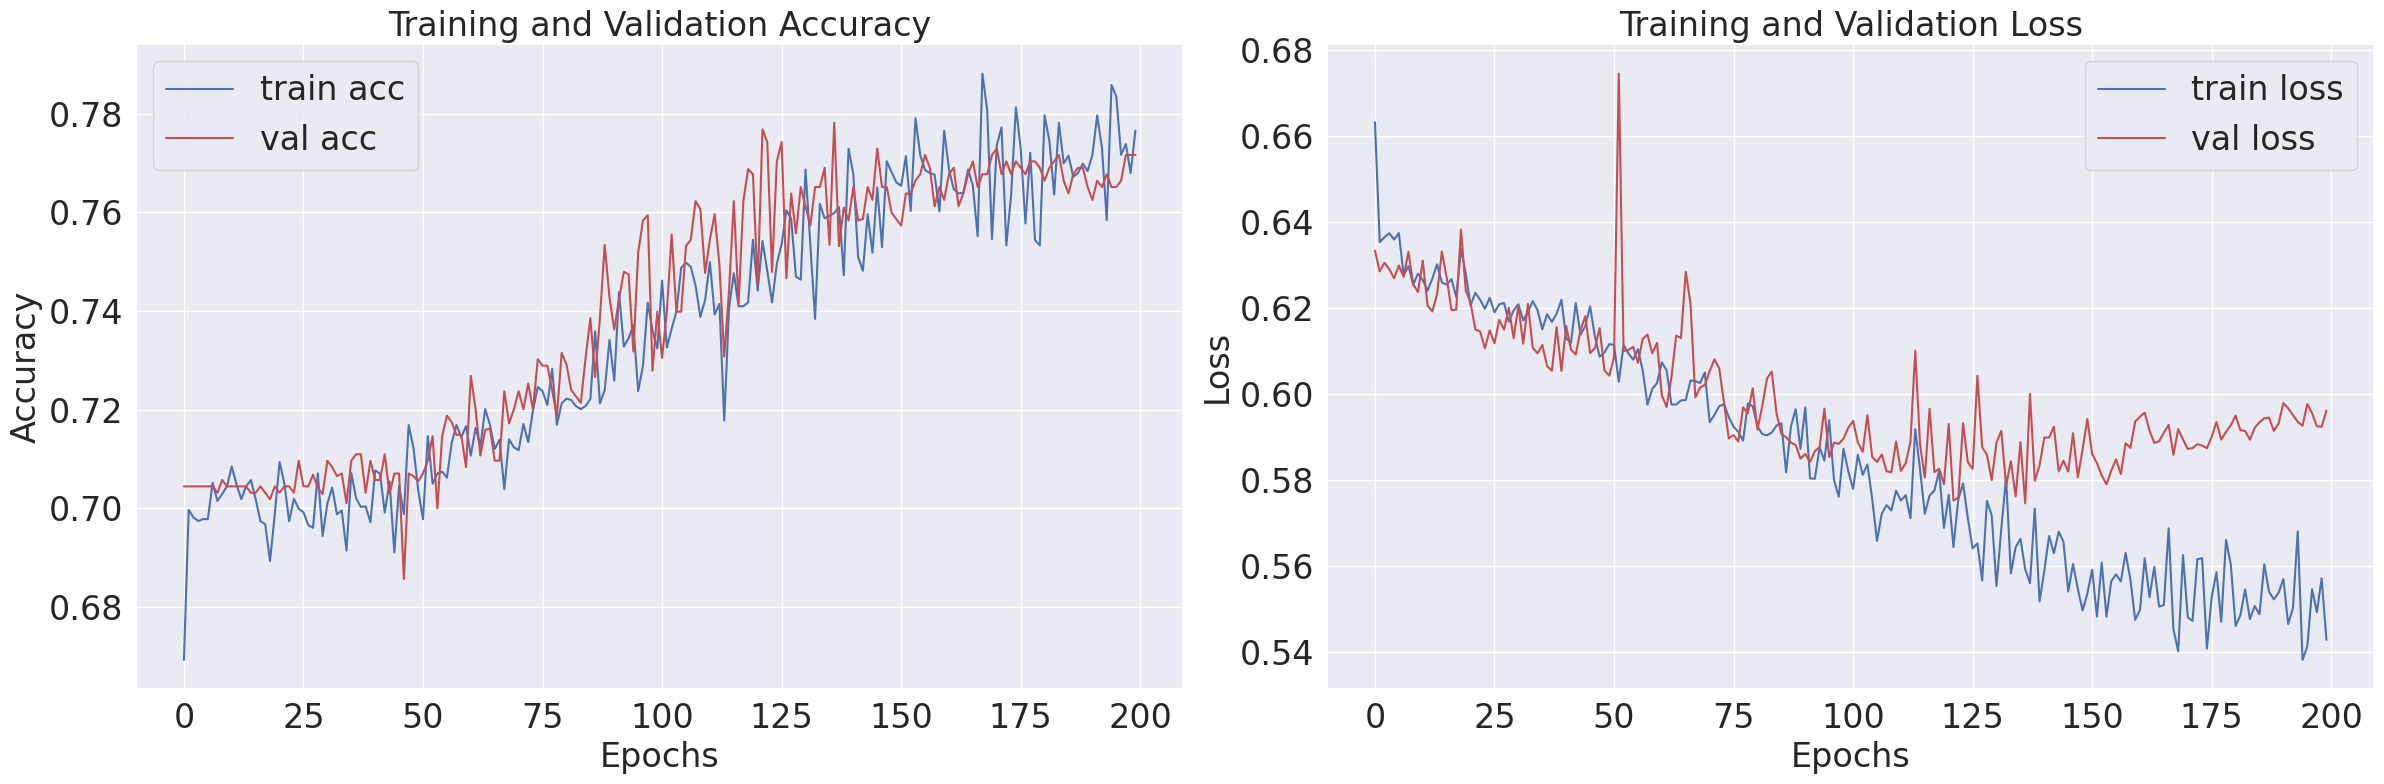

In [26]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 仮にepochsの数をトレーニングデータの長さから取得する
epochs = len(train_acc_list)  # train_acc_listの長さを使用

train_acc = []
train_loss = []
val_acc = []
val_loss = []

# 各リストをnumpy配列に変換し、リストに追加
for i in range(epochs):
    train_acc.append(train_acc_list[i].detach().cpu().numpy())
    train_loss.append(train_loss_list[i].detach().cpu().numpy())
    val_acc.append(val_acc_list[i].detach().cpu().numpy())
    val_loss.append(val_loss_list[i].detach().cpu().numpy())

# グラフ化
sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.plot(range(epochs), train_acc, 'b', label='train acc')
ax1.plot(range(epochs), val_acc, 'r', label='val acc')
ax1.set_title('Training and Validation Accuracy',fontsize=24)
ax1.set_xlabel('Epochs',fontsize=24)
ax1.set_ylabel('Accuracy',fontsize=24)
ax1.legend(fontsize=24)
ax1.tick_params(labelsize=24)

ax2.plot(range(epochs), train_loss, 'b', label='train loss')
ax2.plot(range(epochs), val_loss, 'r', label='val loss')
ax2.set_title('Training and Validation Loss',fontsize=24)
ax2.tick_params(labelsize=24)
ax2.set_xlabel('Epochs',fontsize=24)
ax2.set_ylabel('Loss',fontsize=24)
ax2.legend(fontsize=24)
ax2.tick_params(labelsize=24)
plt.tight_layout()
plt.show()


Extracting validation set logits...


Extracting logits: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Extracting test set logits...


Extracting logits: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Calibrating model...

Validation Set Results:


Calculating confidence interval: 100%|██████████| 1000/1000 [00:05<00:00, 199.64it/s]


Calibrated ROC AUC: 0.7652 [95% CI: 0.7260-0.8024]

Optimal Threshold Analysis (Validation Set):
Optimal threshold: 0.2612
Youden Index: 0.3979
Sensitivity: 0.6991
Specificity: 0.6988
Accuracy: 0.6989
F1-score: 0.5808

Test Set Results:


Calculating confidence interval: 100%|██████████| 1000/1000 [00:04<00:00, 205.18it/s]


Calibrated ROC AUC: 0.6928 [95% CI: 0.6348-0.7528]

Optimal Threshold Analysis (Test Set):
Using validation threshold: 0.2612
Sensitivity: 0.4312
Specificity: 0.8911
Accuracy: 0.7541
F1-score: 0.5109


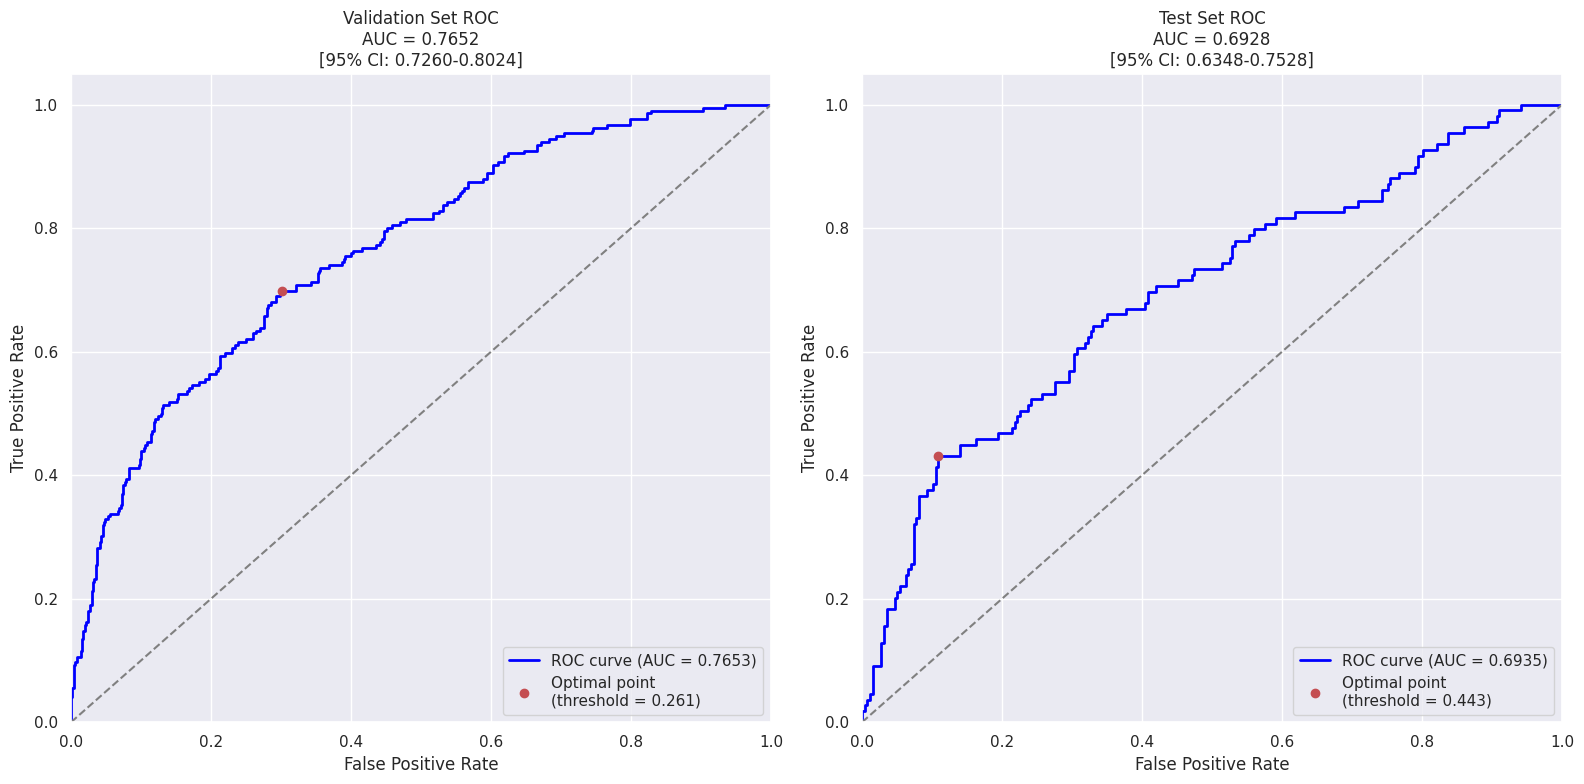

In [27]:
import glob
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from scipy import stats
from tqdm import tqdm
import seaborn as sns

def calculate_metrics(y_true, y_pred):
    """
    基本的な評価指標を計算
    """
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1_score
    }

def calculate_roc_auc_ci(y_true, y_pred, n_bootstraps=1000, confidence_level=0.95):
    """
    ROC-AUCスコアとその信頼区間を計算
    """
    bootstrapped_scores = []
    rng = np.random.RandomState(42)

    for i in tqdm(range(n_bootstraps), desc="Calculating confidence interval"):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)

    alpha = (1 - confidence_level)
    ci_lower = np.percentile(bootstrapped_scores, alpha/2 * 100)
    ci_upper = np.percentile(bootstrapped_scores, (1 - alpha/2) * 100)

    return np.mean(bootstrapped_scores), ci_lower, ci_upper

def calculate_optimal_threshold(y_true, y_pred_proba):
    """
    Youdenインデックスを用いて最適なカットオフ値を計算
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    youden_indices = tpr - fpr
    optimal_idx = np.argmax(youden_indices)
    optimal_threshold = thresholds[optimal_idx]

    y_pred = (y_pred_proba >= optimal_threshold).astype(int)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    youden_index = sensitivity + specificity - 1

    return {
        'threshold': optimal_threshold,
        'youden_index': youden_index,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'accuracy': accuracy,
        'precision': precision,
        'f1_score': f1_score,
        'confusion_matrix': {
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN
        }
    }

def plot_roc_curve_with_optimal_point(y_true, y_pred_proba, title, ax=None):
    """
    ROC曲線と最適カットオフ点をプロット
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc_score = auc(fpr, tpr)

    optimal_metrics = calculate_optimal_threshold(y_true, y_pred_proba)
    optimal_threshold = optimal_metrics['threshold']

    optimal_idx = np.argmin(np.abs(thresholds - optimal_threshold))
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    # 既存のaxを使用するか、新しいfigureを作成
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    # プロット処理をax.plotに変更
    ax.plot(fpr, tpr, color='blue', lw=2,
            label=f'ROC curve (AUC = {auc_score:.4f})')
    ax.plot(optimal_fpr, optimal_tpr, 'ro',
            label=f'Optimal point\n(threshold = {optimal_threshold:.3f})')

    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(True)

    return optimal_metrics

def extract_logits(model, loader, device):
    """
    モデルからロジットを抽出
    """
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in tqdm(loader, desc="Extracting logits"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

def calibrate_and_evaluate(model, valid_loader, test_loader, device):
    """
    モデルのキャリブレーションと評価を実行
    """
    print("Extracting validation set logits...")
    val_logits, val_targets = extract_logits(model, valid_loader, device)

    print("Extracting test set logits...")
    test_logits, test_targets = extract_logits(model, test_loader, device)

    # プラットスケーリングの設定と実行
    print("Calibrating model...")
    calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
    calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

    calibrator.fit(val_logits, val_targets)
    calibrated_model.fit(val_logits, val_targets)

    # 予測確率の取得
    val_probs = calibrated_model.predict_proba(val_logits)[:, 1]
    test_probs = calibrated_model.predict_proba(test_logits)[:, 1]

    # 検証セットの評価
    print("\nValidation Set Results:")
    val_auc, val_ci_lower, val_ci_upper = calculate_roc_auc_ci(val_targets, val_probs)
    print(f"Calibrated ROC AUC: {val_auc:.4f} [95% CI: {val_ci_lower:.4f}-{val_ci_upper:.4f}]")

    # 検証セットの最適カットオフ値を計算
    val_optimal_metrics = calculate_optimal_threshold(val_targets, val_probs)
    print("\nOptimal Threshold Analysis (Validation Set):")
    print(f"Optimal threshold: {val_optimal_metrics['threshold']:.4f}")
    print(f"Youden Index: {val_optimal_metrics['youden_index']:.4f}")
    print(f"Sensitivity: {val_optimal_metrics['sensitivity']:.4f}")
    print(f"Specificity: {val_optimal_metrics['specificity']:.4f}")
    print(f"Accuracy: {val_optimal_metrics['accuracy']:.4f}")
    print(f"F1-score: {val_optimal_metrics['f1_score']:.4f}")

    # テストセットの評価
    print("\nTest Set Results:")
    test_auc, test_ci_lower, test_ci_upper = calculate_roc_auc_ci(test_targets, test_probs)
    print(f"Calibrated ROC AUC: {test_auc:.4f} [95% CI: {test_ci_lower:.4f}-{test_ci_upper:.4f}]")

    # 検証セットで得られた最適カットオフ値をテストセットに適用
    test_metrics = calculate_optimal_threshold(test_targets, test_probs)
    print("\nOptimal Threshold Analysis (Test Set):")
    print(f"Using validation threshold: {val_optimal_metrics['threshold']:.4f}")
    print(f"Sensitivity: {test_metrics['sensitivity']:.4f}")
    print(f"Specificity: {test_metrics['specificity']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"F1-score: {test_metrics['f1_score']:.4f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    val_optimal_metrics = plot_roc_curve_with_optimal_point(
        val_targets, val_probs,
        f"Validation Set ROC\nAUC = {val_auc:.4f}\n[95% CI: {val_ci_lower:.4f}-{val_ci_upper:.4f}]",
        ax=ax1
    )

    test_optimal_metrics = plot_roc_curve_with_optimal_point(
        test_targets, test_probs,
        f"Test Set ROC\nAUC = {test_auc:.4f}\n[95% CI: {test_ci_lower:.4f}-{test_ci_upper:.4f}]",
        ax=ax2
    )

    plt.tight_layout()
    plt.show()

    # モデルを更新
    model.calibrator = calibrated_model

    return {
        'validation': {
            'auc': val_auc,
            'ci_lower': val_ci_lower,
            'ci_upper': val_ci_upper,
            'optimal_metrics': val_optimal_metrics,
            'predictions': val_probs
        },
        'test': {
            'auc': test_auc,
            'ci_lower': test_ci_lower,
            'ci_upper': test_ci_upper,
            'optimal_metrics': test_optimal_metrics,
            'predictions': test_probs
        }
    }

# メインの実行部分
if __name__ == "__main__":
    # モデルのトレーニング後に実行
    results = calibrate_and_evaluate(model, valid_loader, test_loader, device)

In [28]:
model_save_path = '/content/drive/MyDrive/pip_joint_checkpoint'
torch.save(model.state_dict(), model_save_path)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

def extract_logits(model, loader, device):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

# ロジットとターゲットを抽出
val_logits, val_targets = extract_logits(model, valid_loader, device)

# プラットスケーリングを使用してモデルをカリブレーション
calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

# 検証セットのロジットとターゲットを使って、ベースのcalibratorをフィッティング
calibrator.fit(val_logits, val_targets)
# 検証セットの確率を使ってフィッティング
calibrated_model.fit(val_logits, val_targets)

# カリブレーション後の確率を評価
calibrated_probs = calibrated_model.predict_proba(val_logits)[:, 1]

# パフォーマンス評価
roc_auc = roc_auc_score(val_targets, calibrated_probs)
print(f"Calibrated ROC AUC: {roc_auc:.4f}")

# 保存や他の用途で使用するためにモデルを更新
model.calibrator = calibrated_model

Calibrated ROC AUC: 0.7653


/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


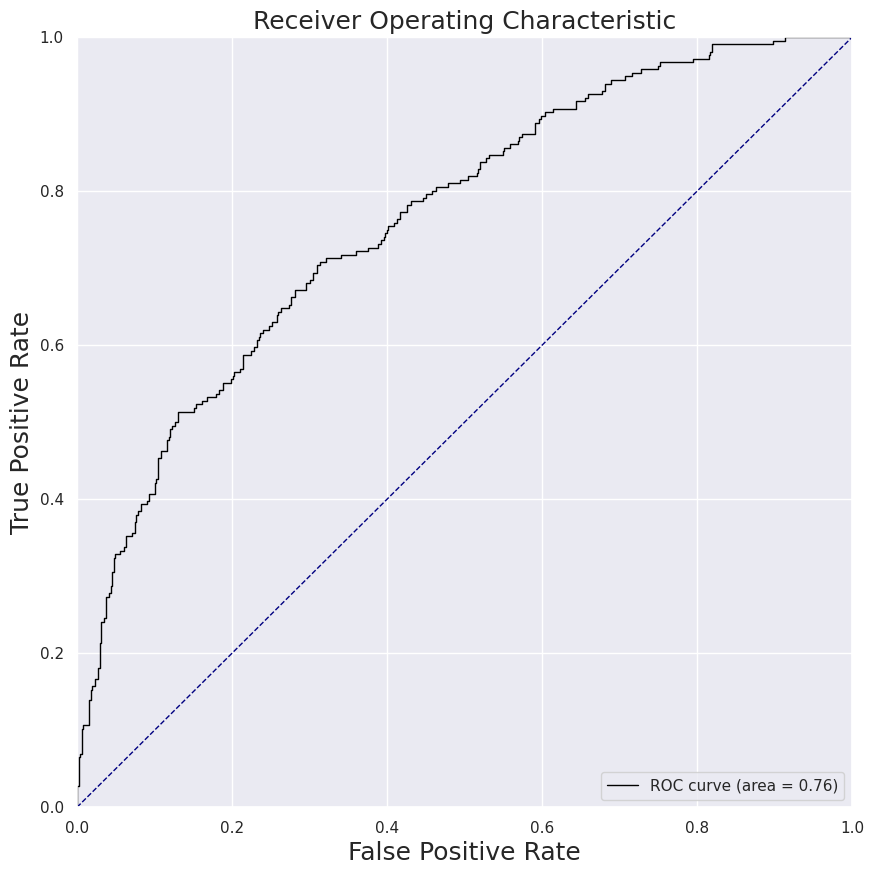

In [30]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(model, loader, device):
    # 真のラベルと予測確率を収集
    true_labels = []
    pred_probs = []

    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            # ソフトマックスを適用して確率を取得
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            pred_probs.extend(probabilities[:, 1].cpu().numpy())  # クラス1の確率を取得
            true_labels.extend(labels.cpu().numpy())

    # ROCカーブの計算
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)

    # ROCカーブの描画
    plt.figure(figsize=(10, 10))
    lw = 1
    plt.plot(fpr, tpr, color='black',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 2], [0, 2], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Receiver Operating Characteristic',fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# 使用例: 有効データローダーとデバイス情報を指定してROC曲線を描画
plot_roc_curve(model, valid_loader, device)


In [31]:
import pickle
# カリブレーターの保存
with open('/content/drive/MyDrive/pip_joint.pkl', 'wb') as f:
    pickle.dump(calibrated_model, f)

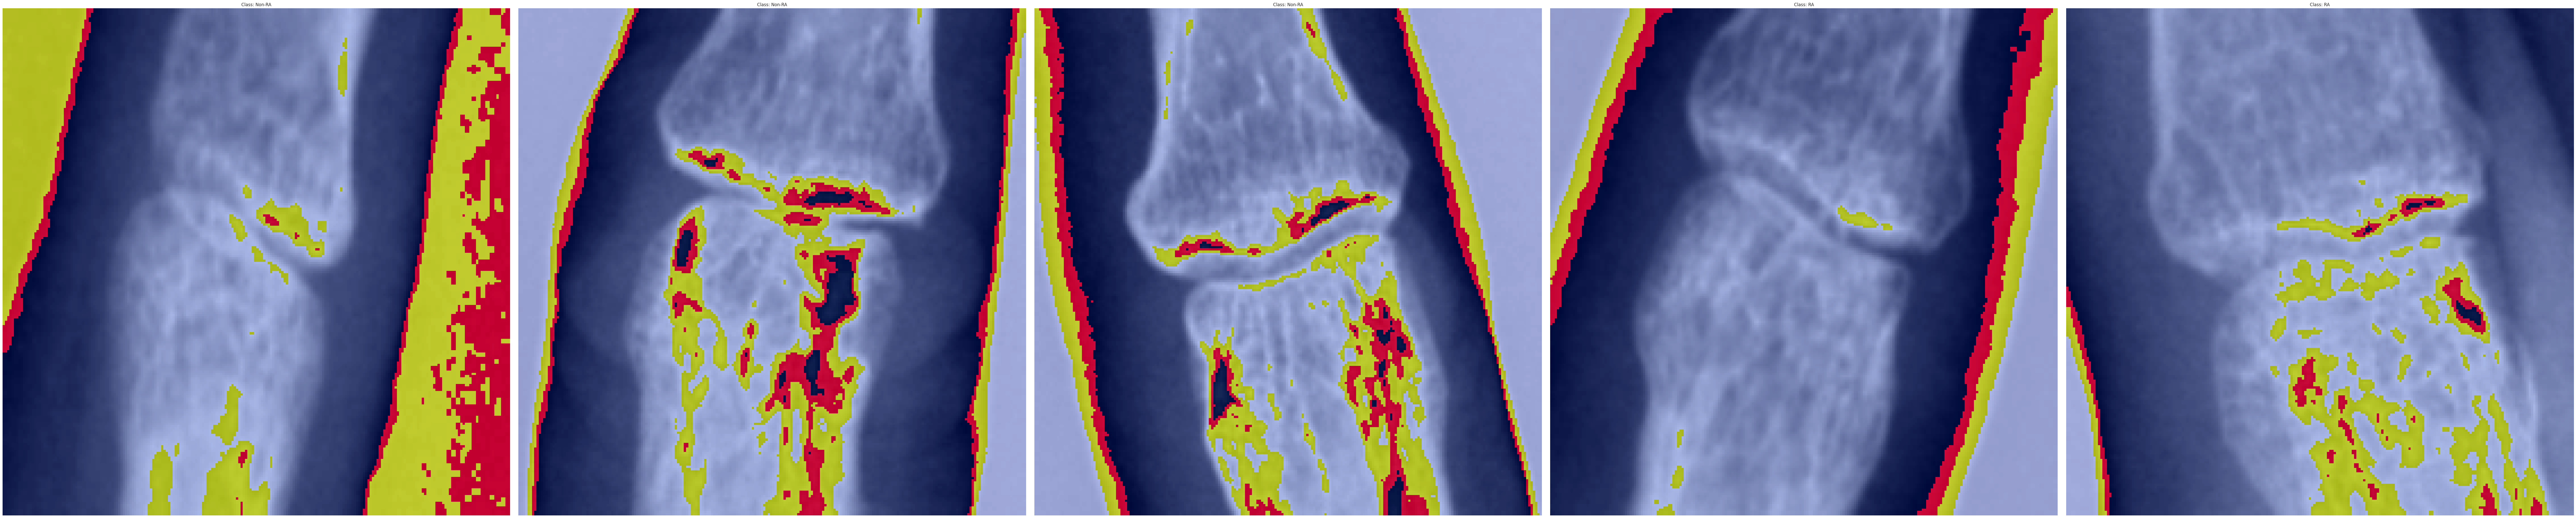

25335

In [32]:
class GradCam:
    def __init__(self, model, device):
        self.model = model
        self.feature = None
        self.gradient = None
        self.device = device

        def forward_hook(module, input, output):
            self.feature = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # Swin Transformerの最後のブロックを取得
        if hasattr(model, 'layers'):
            target_layer = model.layers[-1].blocks[-1]
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_full_backward_hook(backward_hook)
        else:
            raise ValueError("Unexpected model architecture")

    def __call__(self, x):
        self.feature = None
        self.gradient = None

        x = x.to(self.device)

        output = self.model(x)
        pred_class = output.argmax(dim=1)

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, pred_class] = 1
        output.backward(gradient=one_hot)

        # Swin Transformerの特徴量マップの形状に合わせて処理
        feature_map = self.feature
        gradient_map = self.gradient

        # 重みの計算
        weights = gradient_map.mean(dim=(2, 3))  # Swinの場合、spatial dimensionsで平均を取る

        # CAMの計算
        batch_size = feature_map.shape[0]
        height = feature_map.shape[2]
        width = feature_map.shape[3]

        cam = torch.mul(feature_map, weights.view(batch_size, -1, 1, 1))
        cam = cam.sum(dim=1)  # チャネル方向に集約

        # 正規化とReLU
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 元の画像サイズにリサイズ
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)

        return cam

def overlay_heatmap_to_image(image, heatmap):
    image = ((image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    alpha = 0.2
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed / 255.0

# 実行部分
grad_cam = GradCam(model, device)

images, labels = next(iter(test_loader))
images = images[:5]
labels = labels[:5]

plt.figure(figsize=(100, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    try:
        heatmap = grad_cam(image.unsqueeze(0))
        overlayed = overlay_heatmap_to_image(image, heatmap)

        plt.subplot(1, 5, i+1)
        plt.imshow(overlayed)
        plt.title(f'Class: {"RA" if label.item() == 1 else "Non-RA"}')
        plt.axis('off')
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

plt.tight_layout()
plt.show()

torch.cuda.empty_cache()
gc.collect()

<ipython-input-33-968576de812b>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/pip_joint_checkpoint'))


Overall Accuracy: 0.764


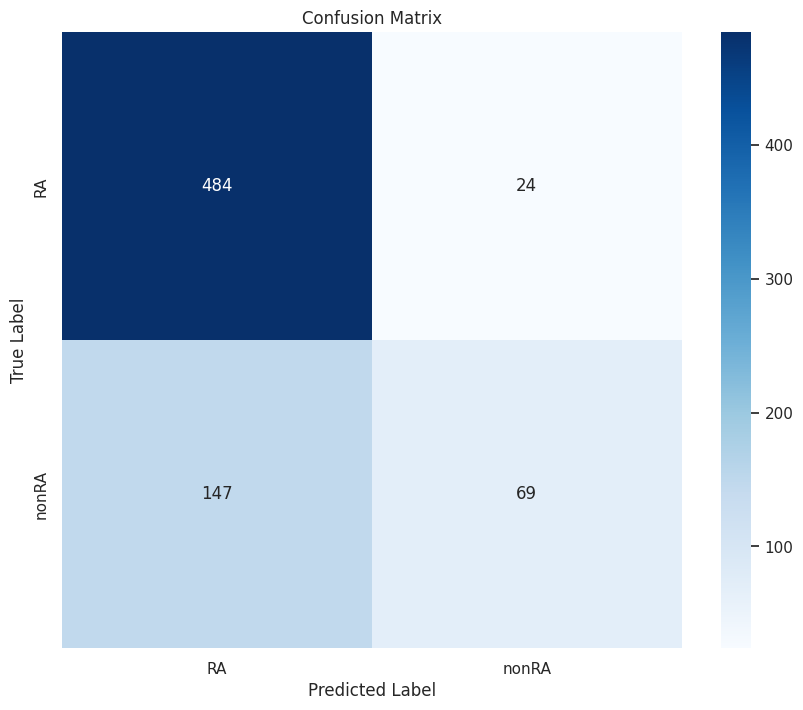

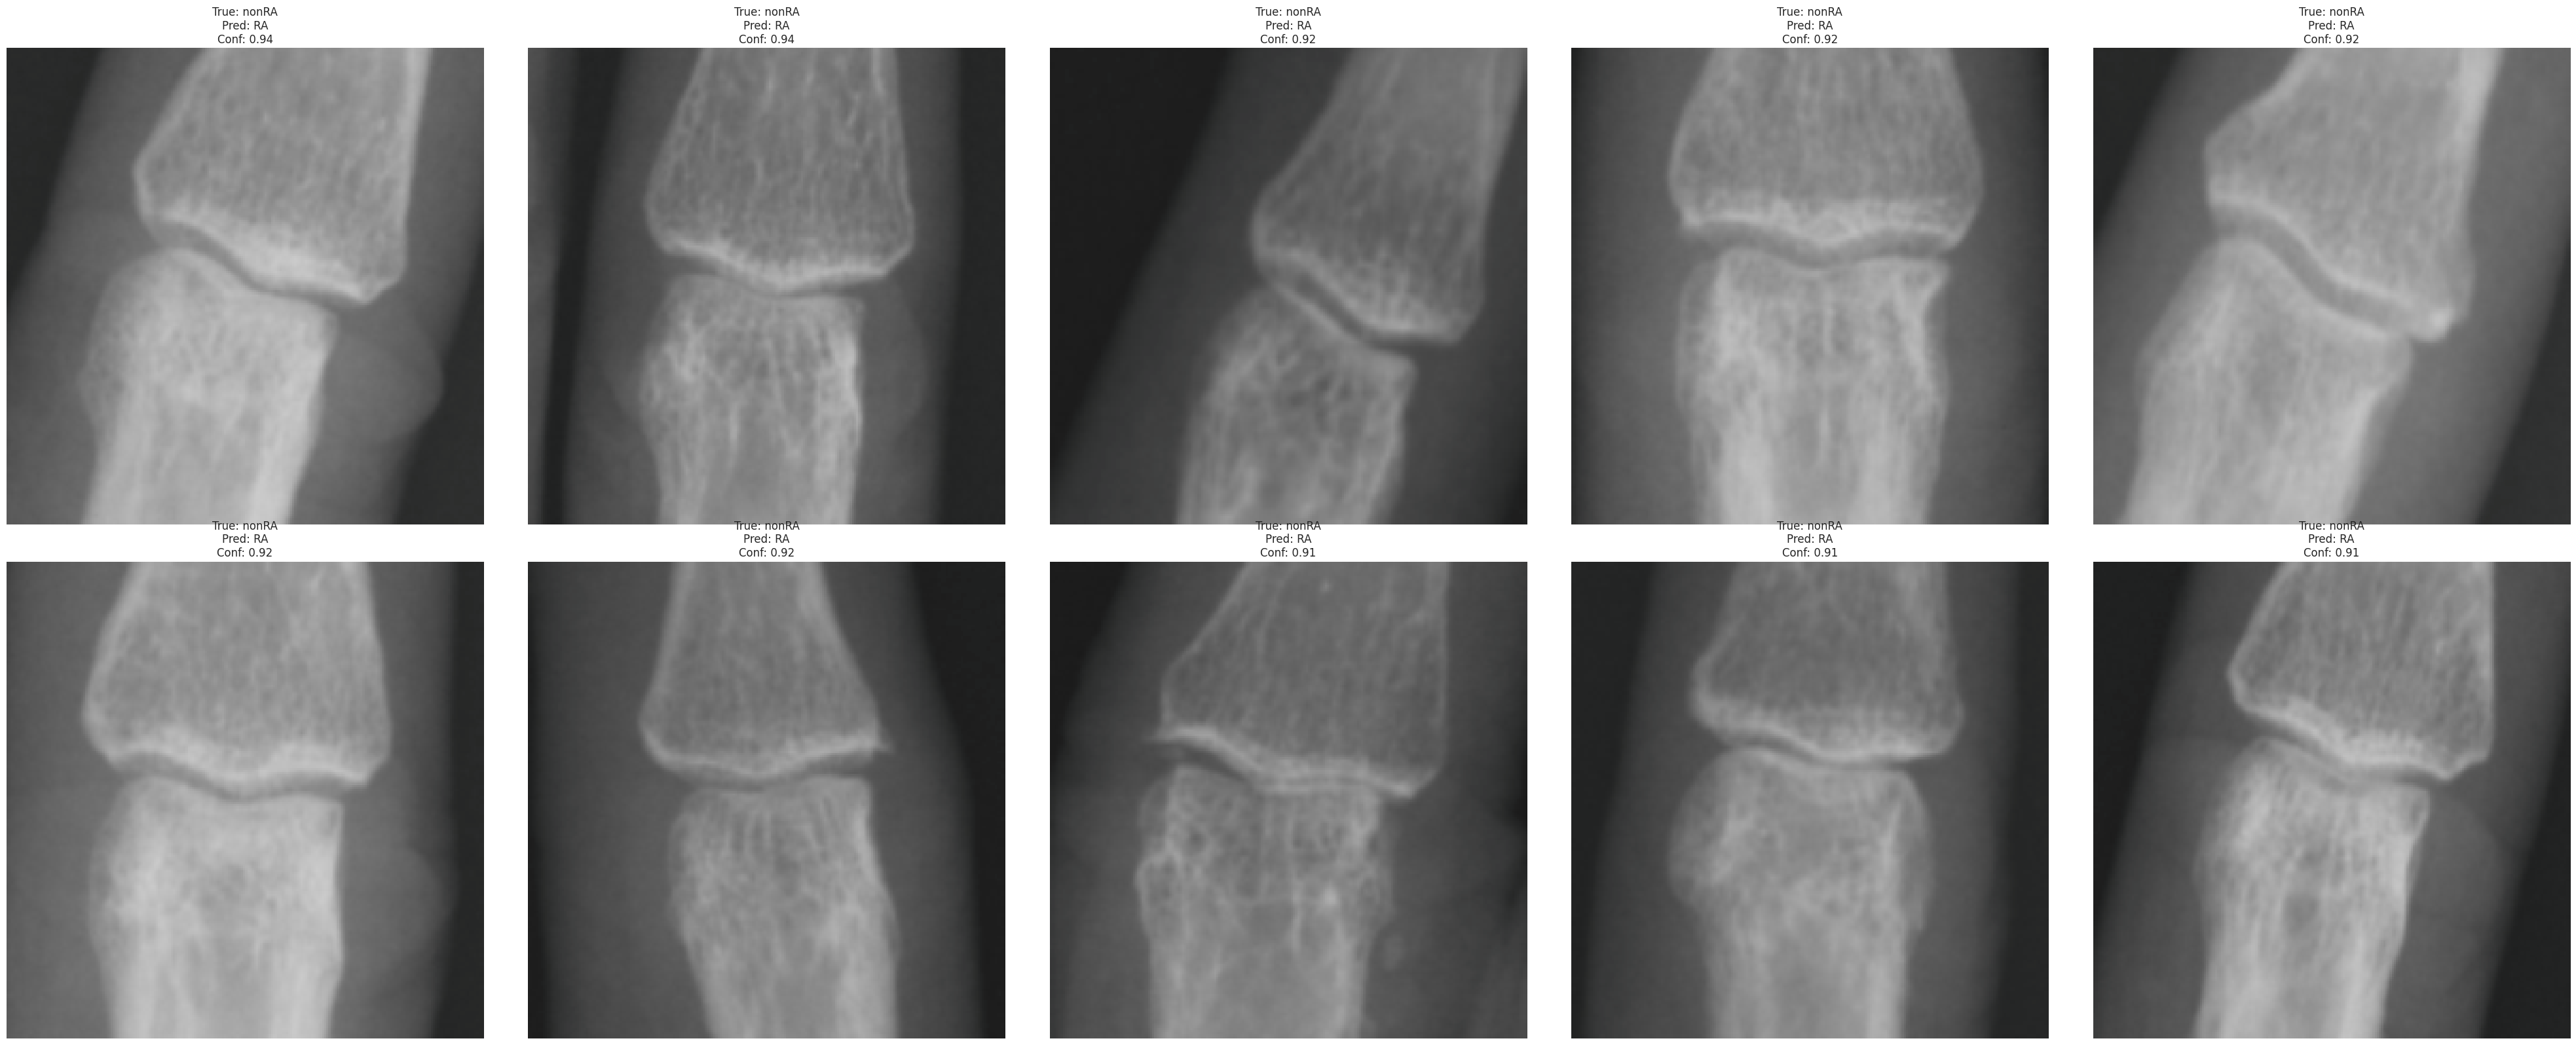

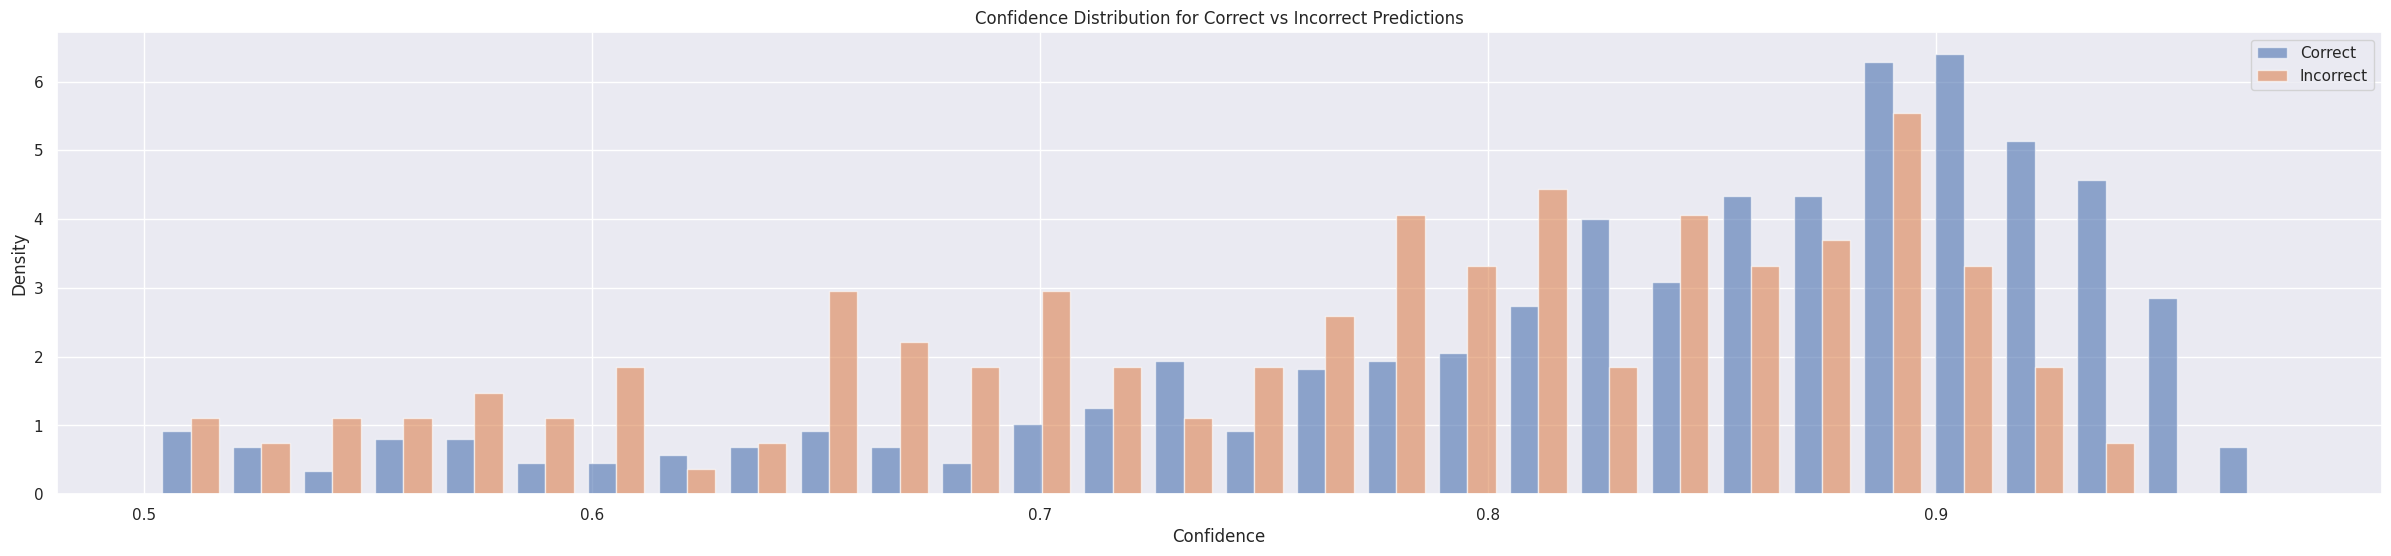


Class RA:
Accuracy: 0.953
Average confidence: 0.840
Samples: 508

Class nonRA:
Accuracy: 0.319
Average confidence: 0.754
Samples: 216


In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def get_predictions(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    images_list = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(conf.cpu().numpy())
            images_list.extend(images.cpu())

    return np.array(predictions), np.array(true_labels), np.array(confidences), images_list

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names):
    misclassified_idx = np.where(predictions != true_labels)[0]

    if len(misclassified_idx) == 0:
        print("No misclassified samples found!")
        return

    sorted_idx = sorted(misclassified_idx,
                       key=lambda x: confidences[x],
                       reverse=True)

    n_samples = min(10, len(sorted_idx))
    fig, axes = plt.subplots(2, 5, figsize=(40, 16))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        if idx < n_samples:
            mis_idx = sorted_idx[idx]
            image = images_list[mis_idx]
            true_label = class_names[true_labels[mis_idx]]
            pred_label = class_names[predictions[mis_idx]]
            conf = confidences[mis_idx]

            # 画像の正規化を元に戻す（必要に応じて調整）
            image = image.permute(1, 2, 0)
            image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            image = torch.clamp(image, 0, 1)

            ax.imshow(image)
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_confidence_distribution(confidences, predictions, true_labels):
    plt.figure(figsize=(30, 6))

    correct = confidences[predictions == true_labels]
    incorrect = confidences[predictions != true_labels]

    plt.hist([correct, incorrect], label=['Correct', 'Incorrect'],
             bins=30, alpha=0.6, density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Correct vs Incorrect Predictions')
    plt.legend()
    plt.show()

# メインの実行コード
def main():
    # デバイスの設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # クラス名の設定（あなたのデータセットに合わせて修正）
    class_names = ['RA', 'nonRA']  # あなたのクラス名に置き換えてください

    model = timm.create_model(
        'swin_base_patch4_window7_224.ms_in1k',
        pretrained=False,
        num_classes=2,
    )

    # モデルの読み込み（あなたの保存したモデルのパスに修正）
    model.load_state_dict(torch.load('/content/drive/MyDrive/pip_joint_checkpoint'))
    model = model.to(device)

    # 予測の実行
    predictions, true_labels, confidences, images_list = get_predictions(model, val_loader, device)

    # 全体の性能メトリクス
    accuracy = np.mean(predictions == true_labels)
    print(f"Overall Accuracy: {accuracy:.3f}")

    # 混同行列の表示
    plot_confusion_matrix(true_labels, predictions, class_names)

    # 誤分類サンプルの表示
    analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names)

    # 確信度分布の表示
    plot_confidence_distribution(confidences, predictions, true_labels)

    # クラスごとの詳細な分析
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        class_acc = np.mean(predictions[class_mask] == true_labels[class_mask])
        print(f"\nClass {class_name}:")
        print(f"Accuracy: {class_acc:.3f}")
        print(f"Average confidence: {np.mean(confidences[class_mask]):.3f}")
        print(f"Samples: {np.sum(class_mask)}")

if __name__ == '__main__':
    val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)  # あなたの検証用DataLoaderを設定

    main()